### Loading the data

In [ ]:
# loading the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

##### Exercise caution while modifying the following cell

In [ ]:
# enter the file path of the given dataset
promo_path = 'Data\Masked_Promo_Data.csv'
scan_path = 'Data\Masked_Scan_Data.csv'

# experiment name
experiment_folder = 'Experiment4(Groupby)'

# choice of target feature
target_feature = 'Vol.Sales'  # as it was recommended in the problem statement

# folder name where we wish to save the files
eda_plots = f'{experiment_folder}\EDA_Plots'  # To save the plots in the EDA process
ppg_retailer_raw_datasets = f'{experiment_folder}\Raw_Data' # To save the PPG X Retailer-wise raw datasets
ppg_retailer_processed_datasets = f'{experiment_folder}\Processed_Data' # To save the PPG X Retailer-wise processed datasets ready for modelling
ppg_retailer_metrics_weights = f'{experiment_folder}\Metrics_Weights' # To save the performance and the coefficients of PPG X Retailer-wise model
ppg_retailer_contributions = f'{experiment_folder}\Contributions' # To save the contributions of all the features towards sales
ppg_retailer_contributions_percent = f'{experiment_folder}\Contributions_Percent'
final_report_folder = f'{experiment_folder}\Final_Report' # To save the final mertrics and relative contributions

# permission to overwrite the files in the above mentioned folder
overwrite_permission = True

# train test split ratio
test_size = 0.2

# top k important features
topK = 3

# parameter to impose positive constraints in the regressions
impose_positive_constraint = True

In [ ]:
# creating the experiment folder if it did not exist already
if experiment_folder not in os.listdir():
    os.mkdir(experiment_folder)

In [ ]:
# setting the style for all the plots
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.dpi'] = 300

sns.set(style='darkgrid')
sns.set_context("notebook", rc={"figure.dpi": 300})

In [ ]:
# reading the datasets

df_promo = pd.read_csv(promo_path, parse_dates=['Date'])
df_scan = pd.read_csv(scan_path, parse_dates=['Date'])

Taking a peak into both the dataframes

In [ ]:
df_promo.head(3).append(df_promo.tail(2))

,Date,PPG,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze,Retailer
0,2018-01-07,Promo.Group 3,1,0,0,0,0,0,Retailer 0
1,2018-01-07,Promo.Group 19,0,1,0,0,0,0,Retailer 0
2,2018-01-07,Promo.Group 22,0,0,0,0,0,0,Retailer 0
1882,2021-01-03,Promo.Group 6,0,0,0,0,0,0,Retailer 1
1883,2021-01-03,Promo.Group 5,0,0,0,0,0,0,Retailer 1


In [ ]:
df_scan.head(3).append(df_scan.tail(2))

,Retailer,Description,Category,Sub.Category,Segment,Sub.Segment,Manufacturer,Brand,Sub.Brand,Packsize,Product.Type,Promo.Group,APN,Date,Unit.Sales,Val.Sales,Vol.Sales,Wtd.Selling.Dist,ppg_to_model
0,Retailer 0,Description 0,Confectionery,Candy Confectionery,Bars,Bars - Bitesize,Manufacturer 0,Brand 0,Sub.Brand 0,38.6g,Product.Type 0,Promo.Group 0,APN 0,2018-10-07,0.0,0.0,0.0,0.0,0
1,Retailer 0,Description 0,Confectionery,Candy Confectionery,Bars,Bars - Bitesize,Manufacturer 0,Brand 0,Sub.Brand 0,38.6g,Product.Type 0,Promo.Group 0,APN 0,2018-10-14,0.0,0.0,0.0,0.0,0
2,Retailer 0,Description 0,Confectionery,Candy Confectionery,Bars,Bars - Bitesize,Manufacturer 0,Brand 0,Sub.Brand 0,38.6g,Product.Type 0,Promo.Group 0,APN 0,2018-10-21,0.0,0.0,0.0,0.0,0
137398,Retailer 1,Description 608,Confectionery,Candy Confectionery,Xmas,NaN,Manufacturer 2,Brand 7,Sub.Brand 63,120g,Product.Type 3,Promo.Group 10,APN 597,2018-09-23,0.0,0.0,0.0,0.0,0
137399,Retailer 1,Description 608,Confectionery,Candy Confectionery,Xmas,NaN,Manufacturer 2,Brand 7,Sub.Brand 63,120g,Product.Type 3,Promo.Group 10,APN 597,2018-09-30,0.0,0.0,0.0,0.0,0


In [ ]:
# checking the dimensions of both the dataframes
print(df_promo.shape, df_scan.shape)

(1884, 9) (137400, 19)


In [ ]:
# checking for nulls

print(df_promo.isna().sum(),'\n')
print(df_scan.isna().sum())

Date                0
PPG                 0
promo_catalogue     0
promo_ins           0
display_platinum    0
display_gold        0
display_silver      0
display_bronze      0
Retailer            0
dtype: int64 

Retailer                0
Description             0
Category                0
Sub.Category            0
Segment                 0
Sub.Segment         10728
Manufacturer            0
Brand                   0
Sub.Brand               0
Packsize                0
Product.Type            0
Promo.Group             0
APN                     0
Date                    0
Unit.Sales              0
Val.Sales               0
Vol.Sales               0
Wtd.Selling.Dist        0
ppg_to_model            0
dtype: int64


On a given date, with a specific retailer, a specific PPG is being applied. These 3 columns are common between the above 2 dataframes and we are going to merge on the above 3 columns

In [ ]:
df_inscope = df_promo.merge(df_scan, left_on=['Date','PPG','Retailer'], right_on=['Date','Promo.Group','Retailer'], how='inner')

In [ ]:
df_inscope.shape

(24408, 26)

In [ ]:
df_inscope.head(3).append(df_inscope.tail(2))

,Date,PPG,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze,Retailer,Description,...,Sub.Brand,Packsize,Product.Type,Promo.Group,APN,Unit.Sales,Val.Sales,Vol.Sales,Wtd.Selling.Dist,ppg_to_model
0,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Description 4,...,Sub.Brand 63,200g,Product.Type 3,Promo.Group 3,APN 4,0.0,0.000,0.00000,0.0,1
1,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Description 5,...,Sub.Brand 63,190g,Product.Type 3,Promo.Group 3,APN 5,0.0,0.000,0.00000,0.0,1
2,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Description 6,...,Sub.Brand 63,220g,Product.Type 3,Promo.Group 3,APN 7,0.0,0.000,0.00000,0.0,1
24406,2020-09-27,Promo.Group 5,0,0,0,0,0,0,Retailer 1,Description 231,...,Sub.Brand 7,520g,Product.Type 1,Promo.Group 5,APN 230,14973.0,74408.862,7.78596,99.8,1
24407,2020-09-27,Promo.Group 5,0,0,0,0,0,0,Retailer 1,Description 604,...,Sub.Brand 7,480g,Product.Type 1,Promo.Group 5,APN 593,0.0,0.000,0.00000,0.0,1


In the following cell, we're checking if the product group is not mixed up. In other words, no item is grouped under two different PPGs

In [ ]:
mapping = dict()
flag = False
for i in range(df_inscope.shape[0]):
    apn = df_inscope.APN.iloc[i]
    ppg = df_inscope.PPG.iloc[i]
    if apn in mapping:
        if mapping[apn] != ppg:
            print('Bad Mapping')
            flag = True
            break
    else:
        mapping[apn] = ppg

if not flag: print('APN --> PPG mapping is done properly')

APN --> PPG mapping is done properly


In [ ]:
# identifying the number of binary/categorical columns

value_counts_inscope = list()  # to check the number of unique values in each feature
drop_cols = list()      # to drop cols with no variance
binary_cols = list()    # to capture binary features which are already 0's and 1's. Won't capture any other binary features
promo_cols = list()     # to capture promo features
display_cols = list()   # to capture display features
sales_cols = list()     # to capture sales features

for col in df_inscope.columns:
    uniq_vals = df_inscope[col].unique()
    value_counts_inscope.append([col, uniq_vals.shape[0]])

    if 'promo_' in col:
        promo_cols.append(col)
    if 'display_' in col:
        display_cols.append(col)
    if '.Sales' in col:
        sales_cols.append(col)

    if uniq_vals.shape[0] == 1:
        drop_cols.append(col)
    if uniq_vals.shape[0] == 2 and set(uniq_vals) == {0,1}:
        binary_cols.append(col)

value_counts_inscope = pd.DataFrame(value_counts_inscope, columns=['Columns','Unique Values'])
value_counts_inscope

,Columns,Unique Values
0,Date,113
1,PPG,6
2,promo_catalogue,2
3,promo_ins,2
4,display_platinum,2
5,display_gold,2
6,display_silver,2
7,display_bronze,2
8,Retailer,2
9,Description,153


In [ ]:
binary_cols

['promo_catalogue',
 'promo_ins',
 'display_platinum',
 'display_gold',
 'display_silver',
 'display_bronze']

In [ ]:
# since the merging was done on PPG also as one of the columns, naturally PPG and Promo.Group are going to be identical
print(np.any(df_inscope['PPG'] != df_inscope['Promo.Group']))

drop_cols.append('Promo.Group')

# also dropping off 'Description' feature as it does not contain any meaningful data
drop_cols.append('Description')

False


In [ ]:
df_inscope.drop(columns=drop_cols, inplace=True)

In [ ]:
# Packsize feature can be converted into a number

def remove_unit(string):
    if string[-2:].lower() == 'kg':
        return float(string[:-2]) * 1000
    elif string[-1:].lower() == 'g':
        return float(string[:-1])
    return np.nan

df_inscope.Packsize = df_inscope.Packsize.apply(remove_unit)

In [ ]:
df_inscope.Packsize.describe()

count    24408.000000
mean       306.916667
std        268.339456
min         99.000000
25%        200.000000
50%        220.000000
75%        260.000000
max       2000.000000
Name: Packsize, dtype: float64

In [ ]:
# checking the info of the dataframe

df_inscope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24408 entries, 0 to 24407
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              24408 non-null  datetime64[ns]
 1   PPG               24408 non-null  object        
 2   promo_catalogue   24408 non-null  int64         
 3   promo_ins         24408 non-null  int64         
 4   display_platinum  24408 non-null  int64         
 5   display_gold      24408 non-null  int64         
 6   display_silver    24408 non-null  int64         
 7   display_bronze    24408 non-null  int64         
 8   Retailer          24408 non-null  object        
 9   Segment           24408 non-null  object        
 10  Sub.Segment       22464 non-null  object        
 11  Brand             24408 non-null  object        
 12  Sub.Brand         24408 non-null  object        
 13  Packsize          24408 non-null  float64       
 14  Product.Type      2440

In [ ]:
# checking the statistical summary

df_inscope.describe()

,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze,Packsize,Unit.Sales,Val.Sales,Vol.Sales,Wtd.Selling.Dist
count,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000,24408.000000
mean,0.287078,0.185062,0.094682,0.059284,0.058014,0.137332,306.916667,3350.732517,9984.759230,0.959443,23.521518
std,0.452408,0.388356,0.292781,0.236160,0.233774,0.344205,268.339456,10250.842996,25712.333497,2.858964,41.246169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,-2.000000,-7.630000,-0.001200,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,260.000000,75.000000,188.880000,0.018720,13.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2000.000000,210075.000000,416176.727000,58.821000,100.000000


In [ ]:
df_inscope.select_dtypes('object').head()

,PPG,Retailer,Segment,Sub.Segment,Brand,Sub.Brand,Product.Type,APN
0,Promo.Group 3,Retailer 0,Candy Bags,NaN,Brand 4,Sub.Brand 63,Product.Type 3,APN 4
1,Promo.Group 3,Retailer 0,Candy Bags,NaN,Brand 4,Sub.Brand 63,Product.Type 3,APN 5
2,Promo.Group 3,Retailer 0,Candy Bags,NaN,Brand 4,Sub.Brand 63,Product.Type 3,APN 7
3,Promo.Group 3,Retailer 0,Candy Bags,NaN,Brand 4,Sub.Brand 63,Product.Type 3,APN 9
4,Promo.Group 3,Retailer 0,Candy Bags,NaN,Brand 4,Sub.Brand 63,Product.Type 3,APN 10


Clearly all the above features are categorical, if we choose to include some of them in the model, we'll encode them after performing EDA.

Since the problem statement requires us to find the coefficients at PPG x Retailer level. Lets create a new feature based of  PPG and Retailer as follows. Also we can produce seasonal features such as week of the day, week of the year, month etc from the Date feature

In [ ]:
df_inscope['PPG_Retailer'] = df_inscope['PPG'] + '__' + df_inscope['Retailer']

In [ ]:
df_inscope['PPG_Retailer'].unique()

array(['Promo.Group 3__Retailer 0', 'Promo.Group 19__Retailer 0',
       'Promo.Group 22__Retailer 0', 'Promo.Group 20__Retailer 0',
       'Promo.Group 6__Retailer 0', 'Promo.Group 5__Retailer 0',
       'Promo.Group 3__Retailer 1', 'Promo.Group 19__Retailer 1',
       'Promo.Group 20__Retailer 1', 'Promo.Group 22__Retailer 1',
       'Promo.Group 6__Retailer 1', 'Promo.Group 5__Retailer 1'],
      dtype=object)

In [ ]:
# Checking if both the types of Promos are mutually exclusive
df_inscope[promo_cols].sum(axis=1).unique()

array([0, 1], dtype=int64)

In [ ]:
# Checking if all the 4 types of Displays are mutually exclusive
df_inscope[display_cols].sum(axis=1).unique()

array([0, 1], dtype=int64)

Clearly both the Promo_ features are mutually exclusive or in other words, if one Promo_ feature is on, the other must be off. Because if both the Promo_ are running simultaneously. Then we would get the sum >= 2.

The above logic applies for 4 Display_ features as well.

In [ ]:
# Checking if all the 6  Promo and Displays are mutually exclusive
df_inscope[promo_cols + display_cols].sum(axis=1).unique()

array([0, 1, 2], dtype=int64)

Since there is a 2, it means that Promo_ and Display_ can co-exist

Looking for obvious anomalies. This is not outlier removal, we will perform them later. Here we're going to remove obvious errors like having negative sales or having 0 unit sales but non-zero dollar sales etc

In [ ]:
# There are 3 types of sales: Unit Sales, Value Sales, Volume Sales
def find_negatives_in_sales(df):

    negative_indices = set()
    for col in df.columns:
        if '.sales' in col.lower():
            negative_indices = negative_indices.union(set(df[df[col] < 0].index))

    if negative_indices:
        print(f"There are {len(negative_indices)} indices with negative sales value\n")
        return list(negative_indices)
    print('There are no negative sales value\n')

In [ ]:
# Negative sales of any form is obvious anomaly. Lets drop those indices
negatives = find_negatives_in_sales(df_inscope)
df_inscope.drop(index=negatives, inplace=True)

There are 33 indices with negative sales value



In [ ]:
# Checking again if the negative indices are successfully removed
negatives_check = find_negatives_in_sales(df_inscope)

There are no negative sales value



Now we're looking for the anomalies where one of the sales is zero, whereas the other type of sales is non-zero

In [ ]:
def disparity_in_zero_sales(df):

    zero_indices = dict()
    sales_cols = list()
    for col in df.columns:
        if '.sales' in col.lower():
            sales_cols.append(col)
            zero_indices[col] = set(df[df[col] == 0].index)

    remove_indices = set()
    n = len(sales_cols)
    for i in range(n - 1):
        for j in range(i + 1, n):
            remove_indices = remove_indices.union(zero_indices[sales_cols[i]] - zero_indices[sales_cols[j]])
            remove_indices = remove_indices.union(zero_indices[sales_cols[j]] - zero_indices[sales_cols[i]])

    if remove_indices:
        print(f"There are {len(remove_indices)} indices with sales disparity\n")
        return list(remove_indices)
    print('There are no sales disparities\n')

Clearly zero_units and zero_volume are same. But zero_units and zero_value are not. Lets find the indices where they're different

In [ ]:
# getting the list of zero sales disparities
disparity = disparity_in_zero_sales(df_inscope)
df_inscope.drop(index=disparity, inplace=True)

There are 4 indices with sales disparity



In [ ]:
# checking again if the disparities are removed
disparity_check = disparity_in_zero_sales(df_inscope)

There are no sales disparities



In [ ]:
df_inscope.reset_index(drop=True, inplace=True)

In [ ]:
# function to check if the dates are weekly and contiguous

def checking_Data_continuity(df):

    datedf = df[['Date']].drop_duplicates().sort_values('Date')
    myset = set()
    for i in range(datedf.shape[0] - 1):
        myset.add((datedf.Date.iloc[i + 1] - datedf.Date.iloc[i]).days)

    return myset == {7}

In [ ]:
checking_Data_continuity(df_inscope)

True

Since the difference between a date and its preceding date is exactly 7 days. It implies that the dates are in weekly and there are no missing dates

In [ ]:
# Checking if Weighted Selling Distribution is negative

(df_inscope['Wtd.Selling.Dist'] < 0).sum()

0

In [ ]:
# Checking if Vol.Sales is basically same as Unit.Sales times Packsize

np.all(df_inscope['Vol.Sales'] == df_inscope['Packsize'] * df_inscope['Unit.Sales'] / 1e6)

True

Note that volume is measured in metric tons

### Exploratory Data Analysis

Analyzing the sales features

In [ ]:
# creating the folder for datasets if it did not exist already
if eda_plots not in os.listdir():
    os.mkdir(eda_plots)

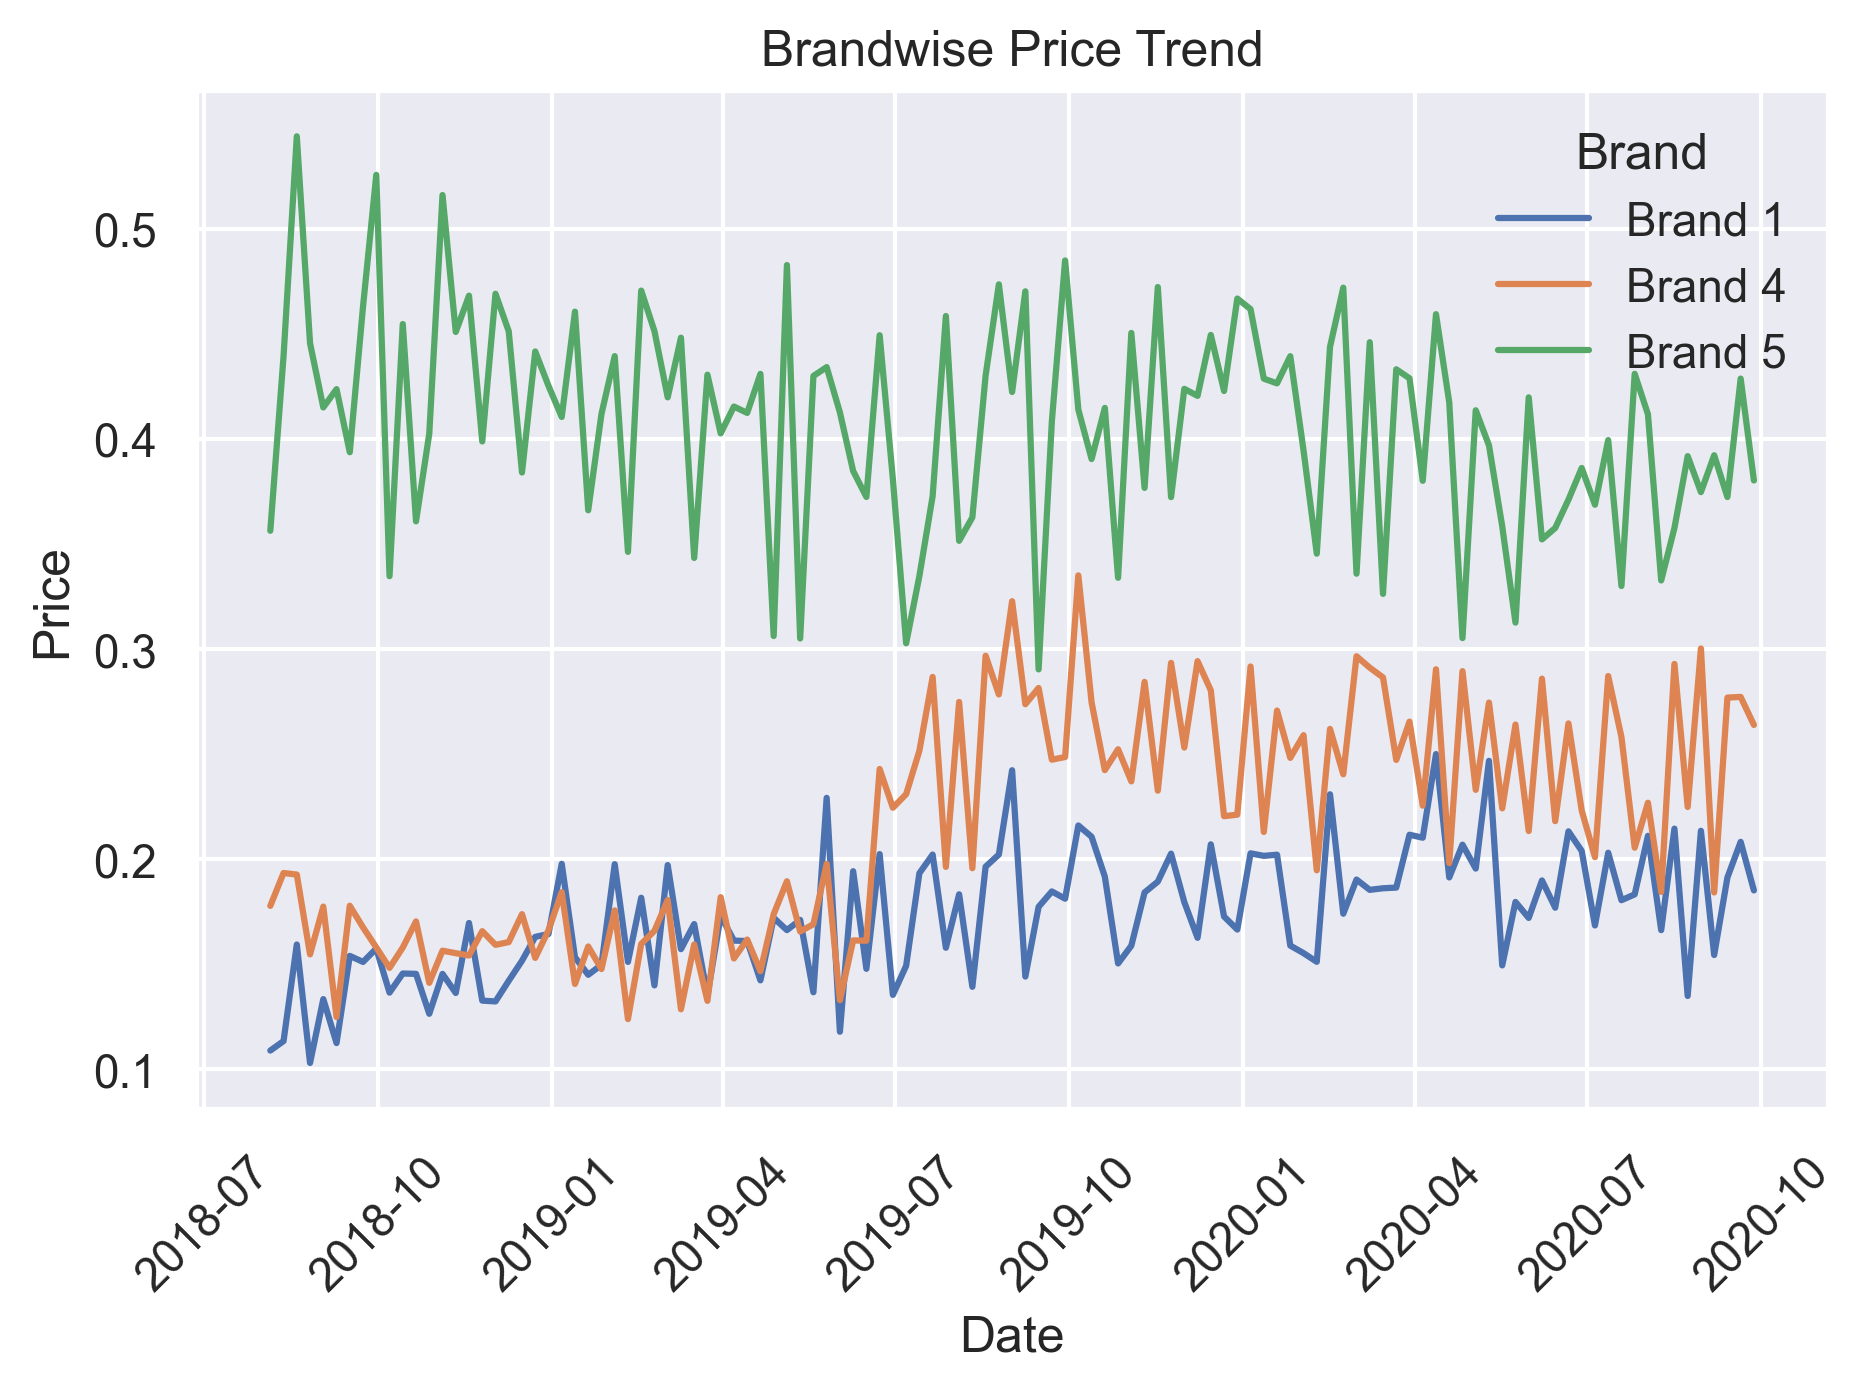

In [ ]:
temp = df_inscope.copy()
temp['Price'] = temp['Val.Sales'] / (temp['Vol.Sales'] * 1e6)
temp = temp.groupby(['Date','Brand']).agg({'Price':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Price'],hue=temp['Brand'])
plt.xticks(rotation=45)
plt.title('Brandwise Price Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Price_Trend.png")

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby('Date').agg({'Vol.Sales':'sum', 'Unit.Sales':'sum', 'Val.Sales':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)

In [ ]:
temp

,Date,Vol.Sales,Unit.Sales,Val.Sales
0,2018-08-05,213.164230,713352.0,2372864.787
1,2018-08-12,164.777280,515711.0,1872530.765
2,2018-08-19,135.000590,410644.0,1643815.265
3,2018-08-26,333.724775,1240732.0,3002664.498
4,2018-09-02,211.649060,728504.0,2323405.764
...,...,...,...,...
108,2020-08-30,158.566490,528713.0,1908779.294
109,2020-09-06,224.137010,818352.0,2242920.080
110,2020-09-13,210.235195,718652.0,2119723.961
111,2020-09-20,147.275870,478097.0,1837928.830


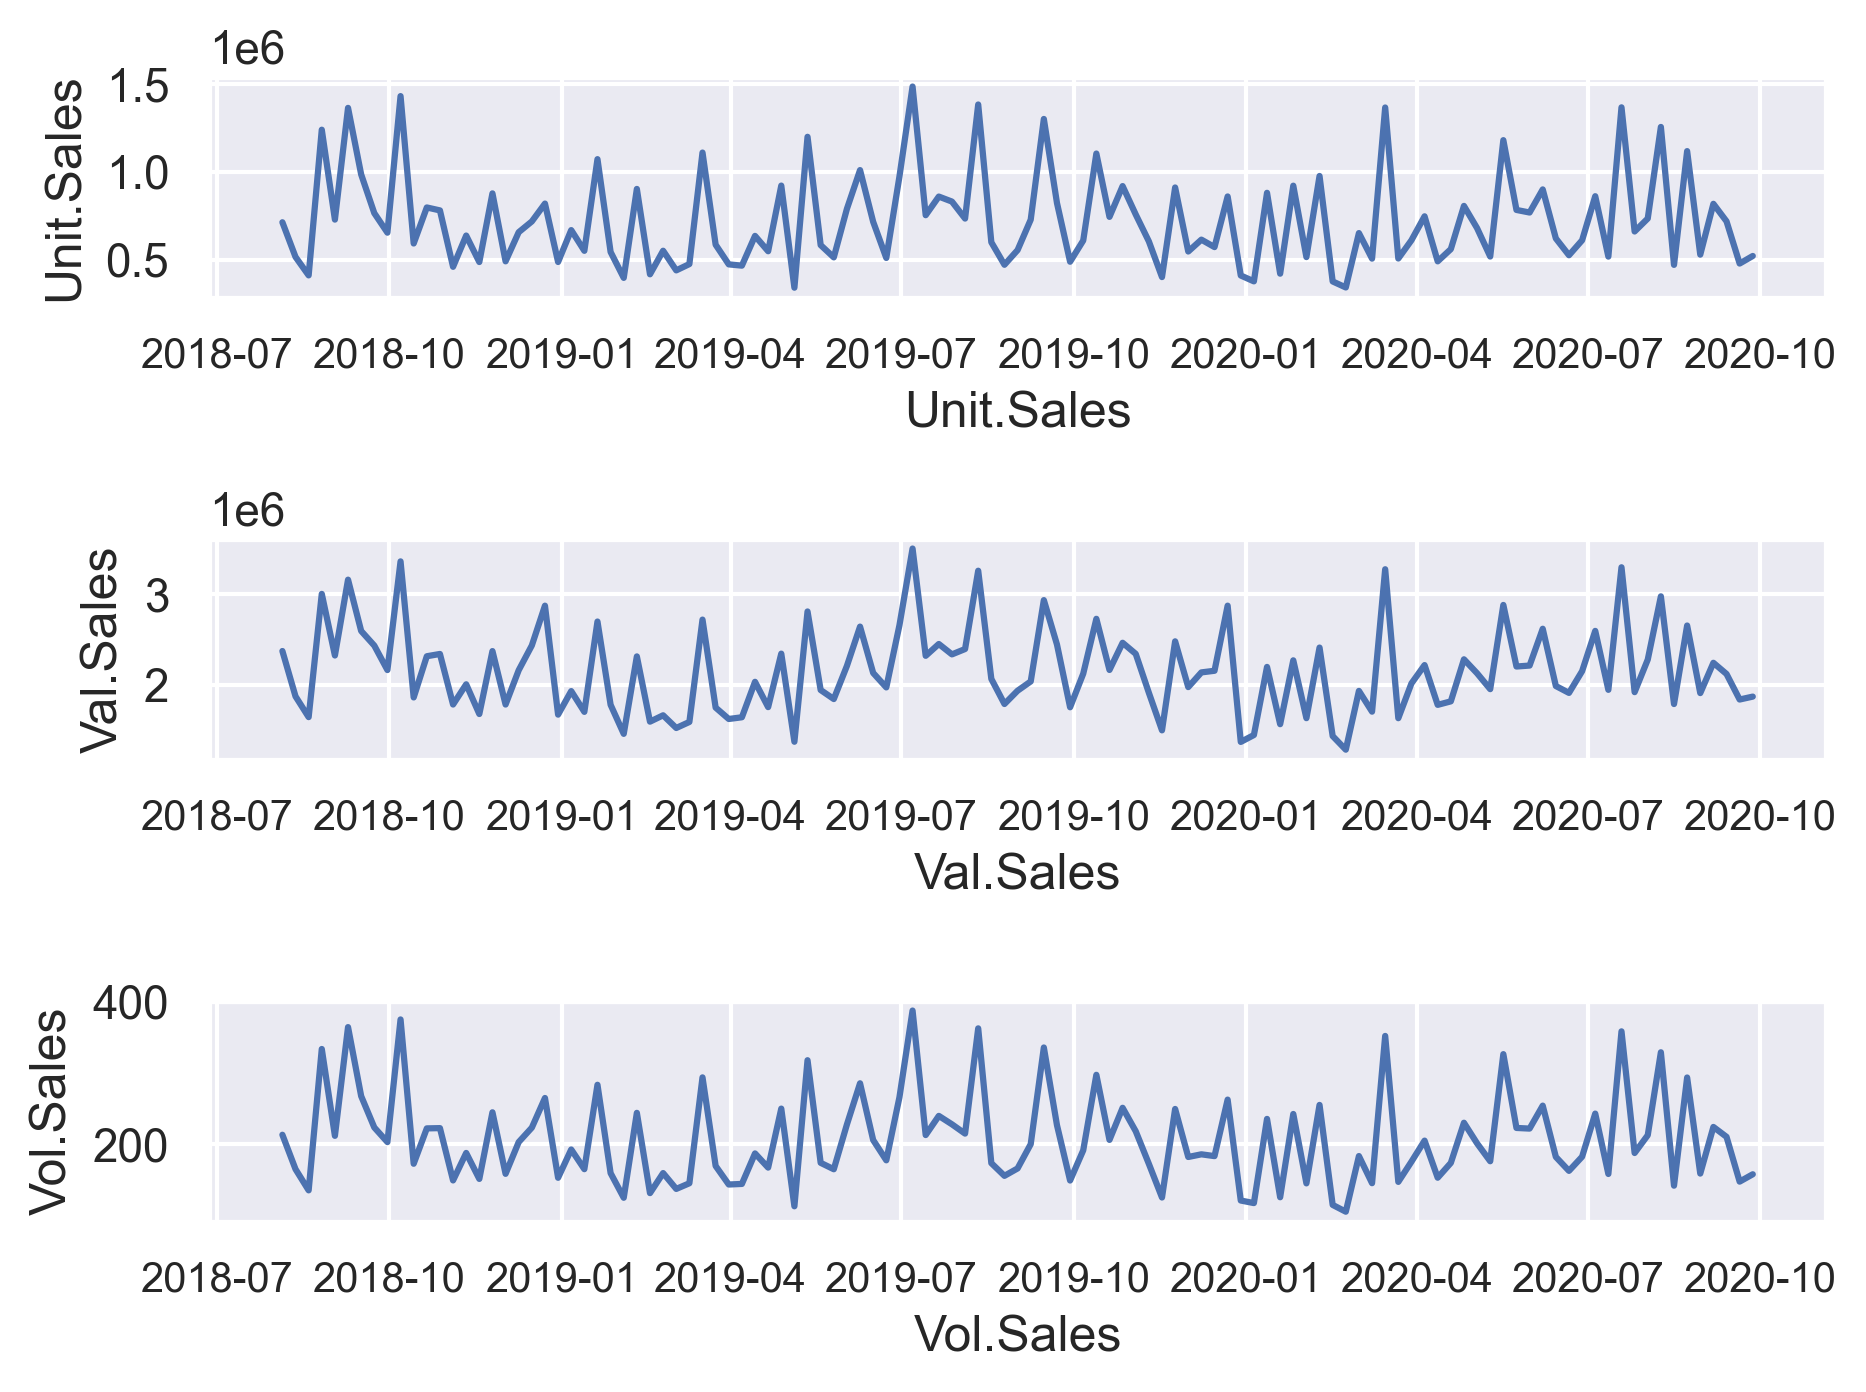

In [ ]:
for i, col in enumerate(sales_cols):
    plt.subplot(3,1,i+1)
    sns.lineplot(temp['Date'], temp[col])
    plt.xlabel(col)
    plt.xticks(fontsize=10);

plt.tight_layout()

In [ ]:
df_inscope[sales_cols].corr()

,Unit.Sales,Val.Sales,Vol.Sales
Unit.Sales,1.000000,0.943846,0.961374
Val.Sales,0.943846,1.000000,0.978659
Vol.Sales,0.961374,0.978659,1.000000


Since the problem statement says that we need to build a model on Volume Sales and also since graphically and analytically we see that these 3 sales cols are highly correlated. We'll drop off Value Sales and Unit Sales

In [ ]:
df_inscope.drop(columns=['Unit.Sales', 'Val.Sales'], inplace=True)

In [ ]:
# Checking for different combinations of features to obtain primary key

df_inscope.duplicated(subset=['Date', 'PPG_Retailer', 'APN']).sum()

0

Since the triplet of 'Date', 'PPG_Retailer', 'APN' has no duplicated triplet. Note each of the feature within itself may have duplicates. In business terms we can look at it like, each entry (row) corresponds to a specific combination of a given day, a given PPG_Retailer, and a specific item within the package.

Introducing derived seasonality features such as week of the year, month of the year, quarter of the year etc

In [ ]:
df_inscope['WeekNum'] = df_inscope.Date.dt.weekofyear
df_inscope['Month'] = df_inscope.Date.dt.month
df_inscope['Quarter'] = df_inscope.Date.dt.quarter
df_inscope['Year'] = df_inscope.Date.dt.year
df_inscope['Month_Year'] = df_inscope['Month'].astype('str') + '__' + df_inscope['Year'].astype('str')

In [ ]:
df_inscope.head()

,Date,PPG,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze,Retailer,Segment,...,Product.Type,APN,Vol.Sales,Wtd.Selling.Dist,PPG_Retailer,WeekNum,Month,Quarter,Year,Month_Year
0,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Candy Bags,...,Product.Type 3,APN 4,0.0,0.0,Promo.Group 3__Retailer 0,31,8,3,2018,8__2018
1,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Candy Bags,...,Product.Type 3,APN 5,0.0,0.0,Promo.Group 3__Retailer 0,31,8,3,2018,8__2018
2,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Candy Bags,...,Product.Type 3,APN 7,0.0,0.0,Promo.Group 3__Retailer 0,31,8,3,2018,8__2018
3,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Candy Bags,...,Product.Type 3,APN 9,0.0,0.0,Promo.Group 3__Retailer 0,31,8,3,2018,8__2018
4,2018-08-05,Promo.Group 3,0,0,0,0,0,0,Retailer 0,Candy Bags,...,Product.Type 3,APN 10,0.0,0.0,Promo.Group 3__Retailer 0,31,8,3,2018,8__2018


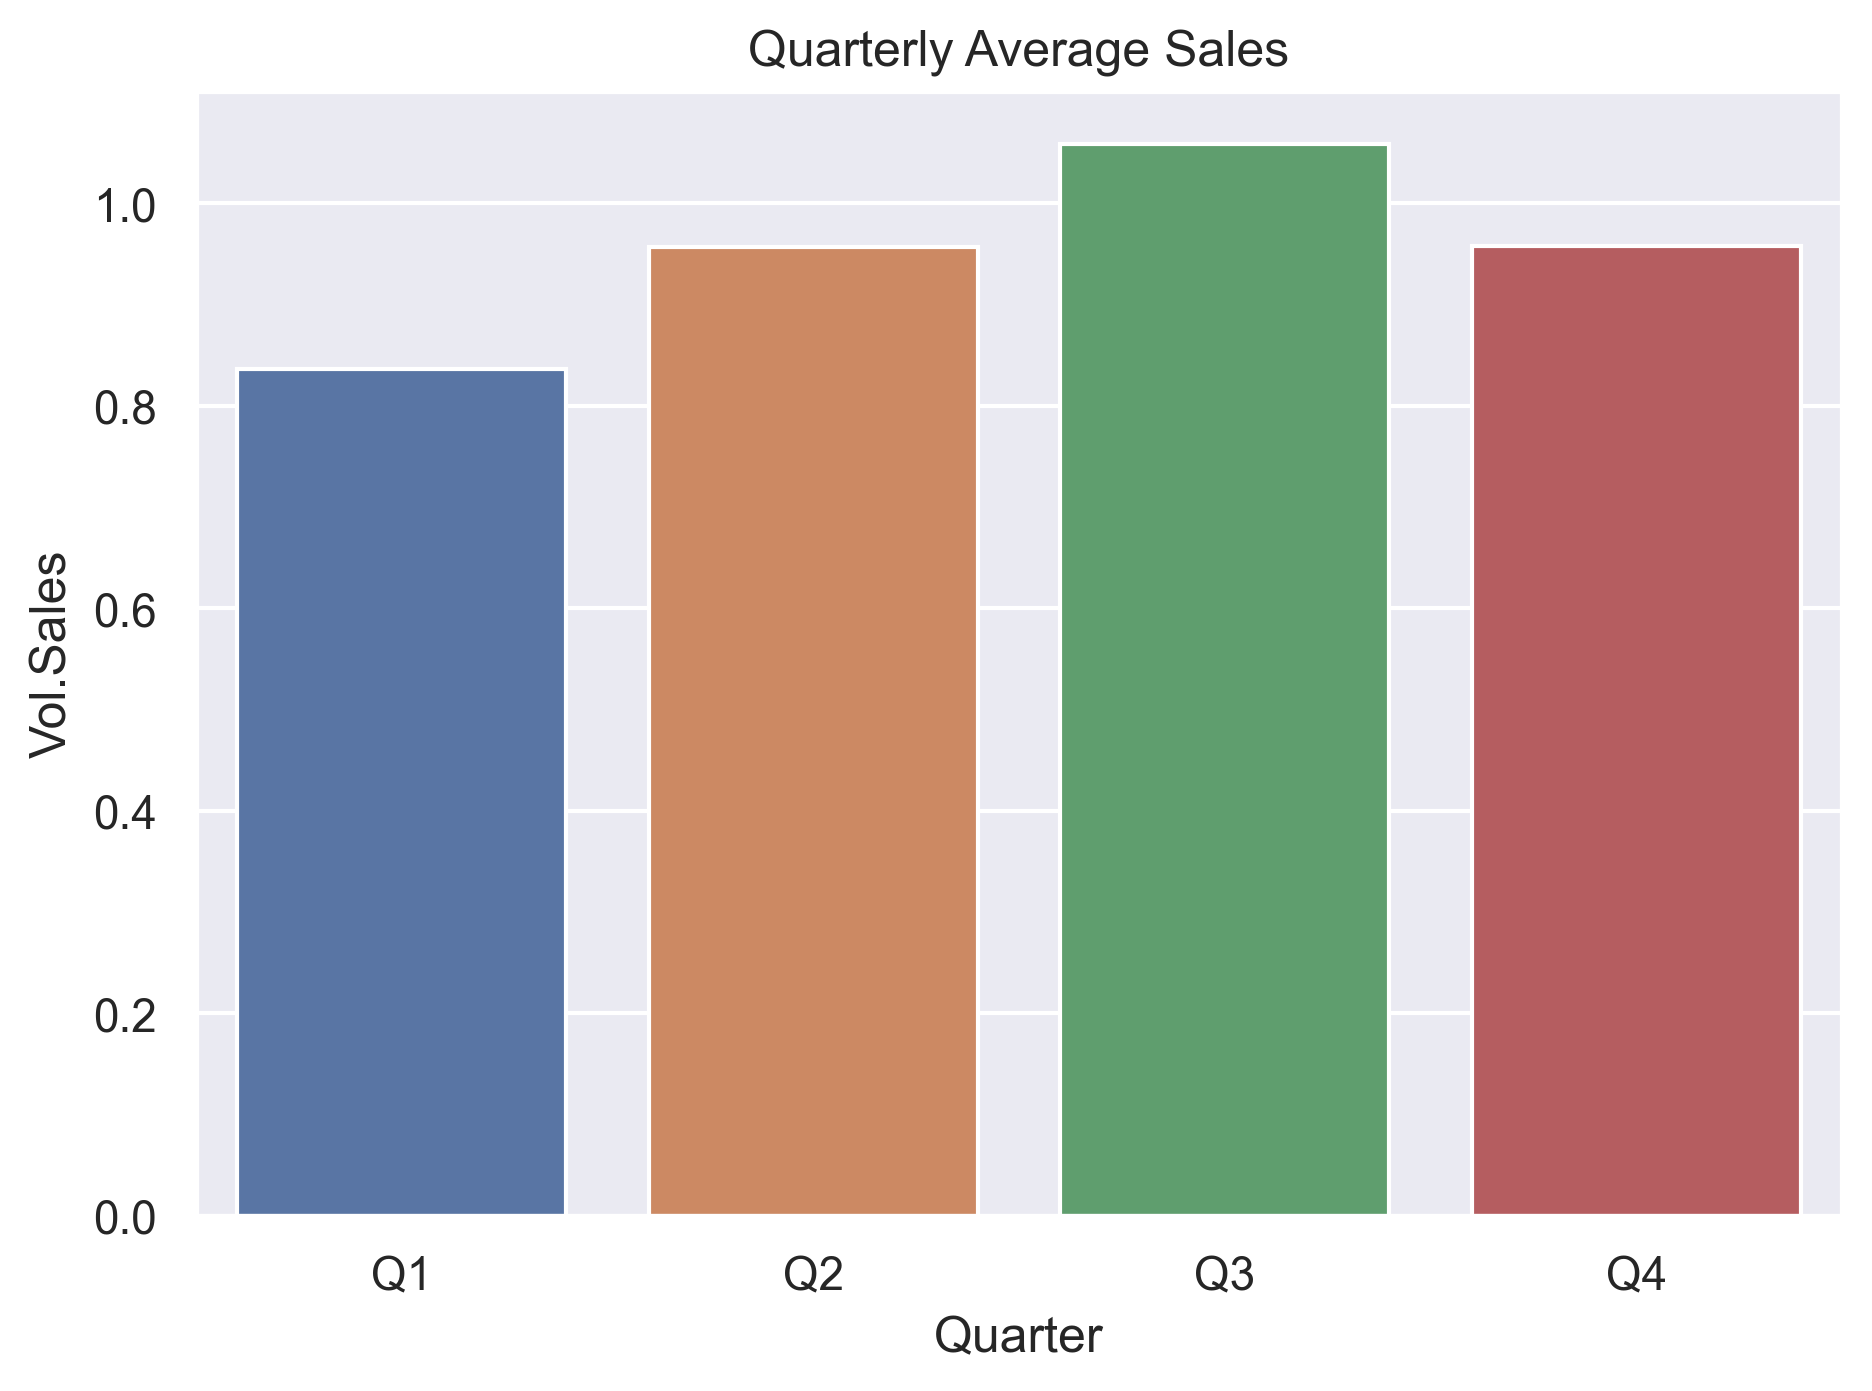

In [ ]:
temp = df_inscope.copy()
temp['Quarter'] = temp['Quarter'].map({1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'})
temp = temp.groupby(['Quarter']).agg({'Vol.Sales':'mean'}).reset_index()
sns.barplot(temp['Quarter'],temp['Vol.Sales'])
plt.title('Quarterly Average Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Quarterly_Average_Sales.png")

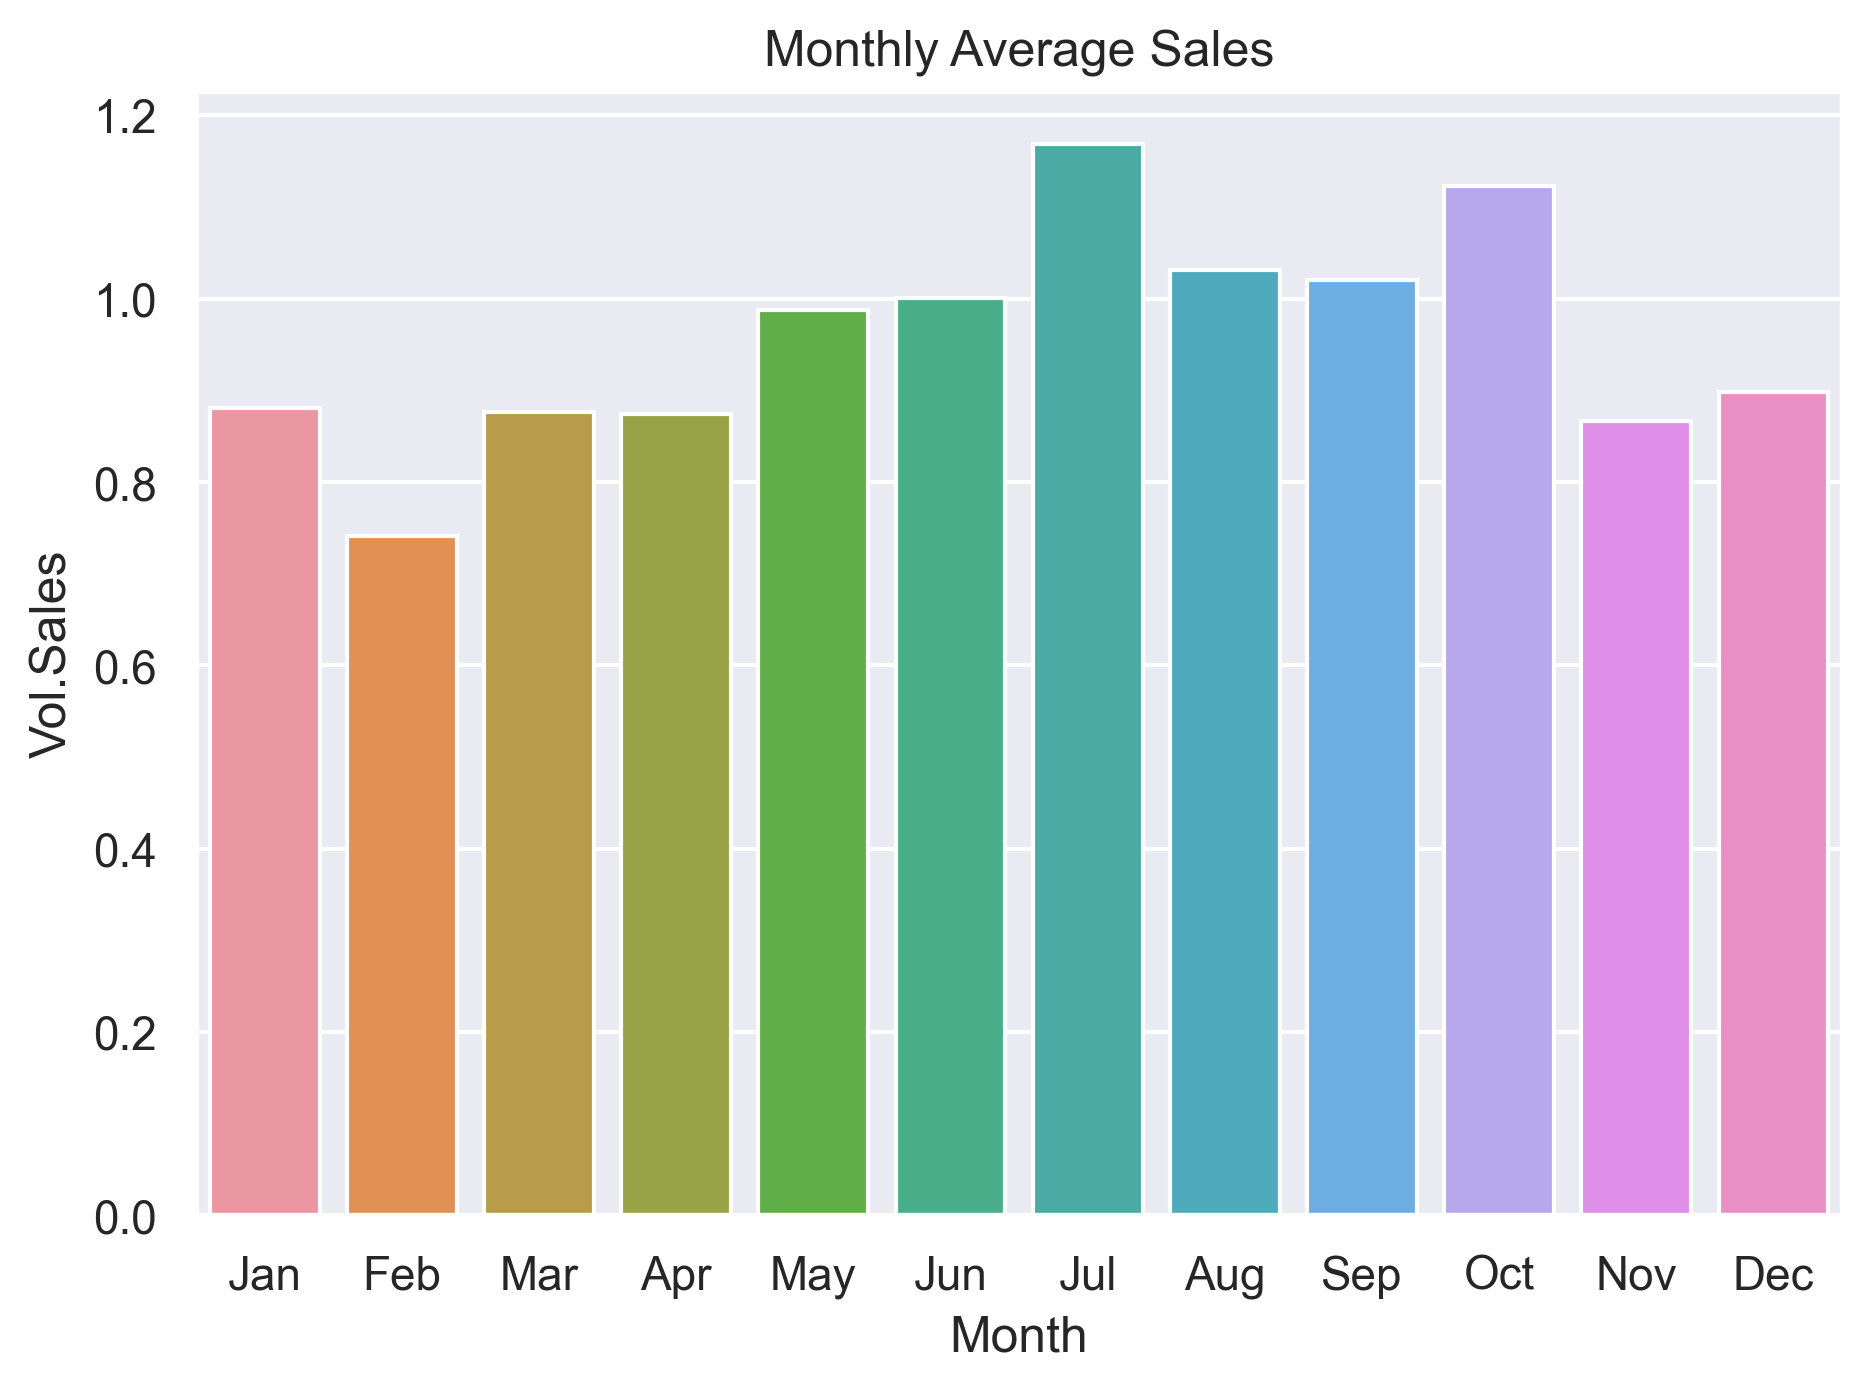

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['Month']).agg({'Vol.Sales':'mean'}).reset_index()
temp['Month'] = temp['Month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',
                                 10:'Oct',11:'Nov',12:'Dec'})
sns.barplot(temp['Month'],temp['Vol.Sales'])
plt.xticks(rotation=0)
plt.title('Monthly Average Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Monthly_Average_Sales.png")

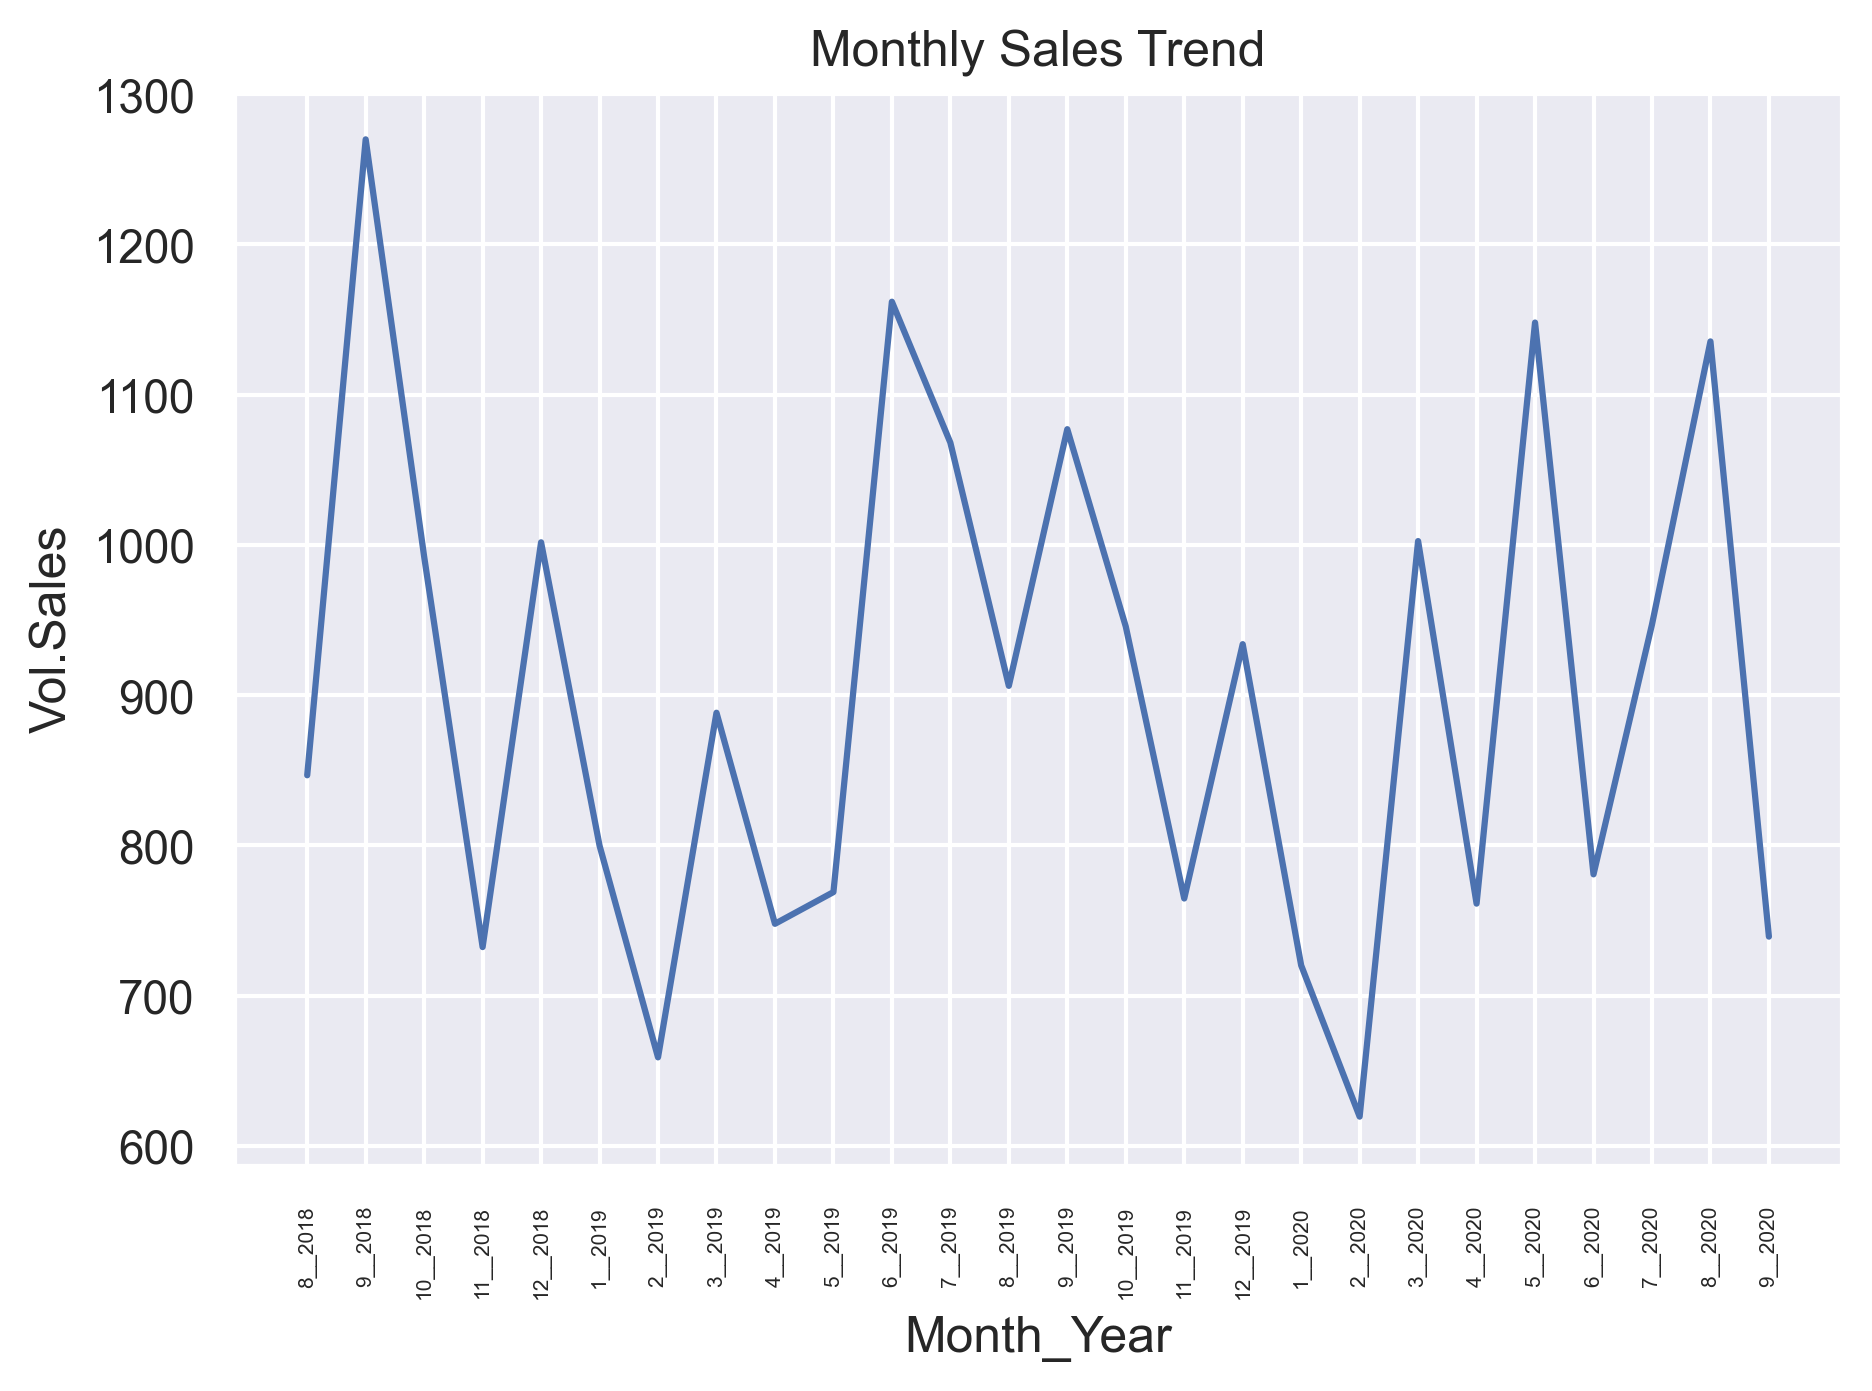

In [ ]:
temp = df_inscope.copy()
temp['sorting_helper'] = list(zip(df_inscope['Year'], df_inscope['Month']))
temp = temp.groupby(['Month_Year']).agg({'Vol.Sales':'sum', 'sorting_helper':'first'}).reset_index()
temp.sort_values('sorting_helper', inplace=True)
sns.lineplot(temp['Month_Year'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=5)
plt.title('Monthly Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Monthly_Sales_Trend.png")

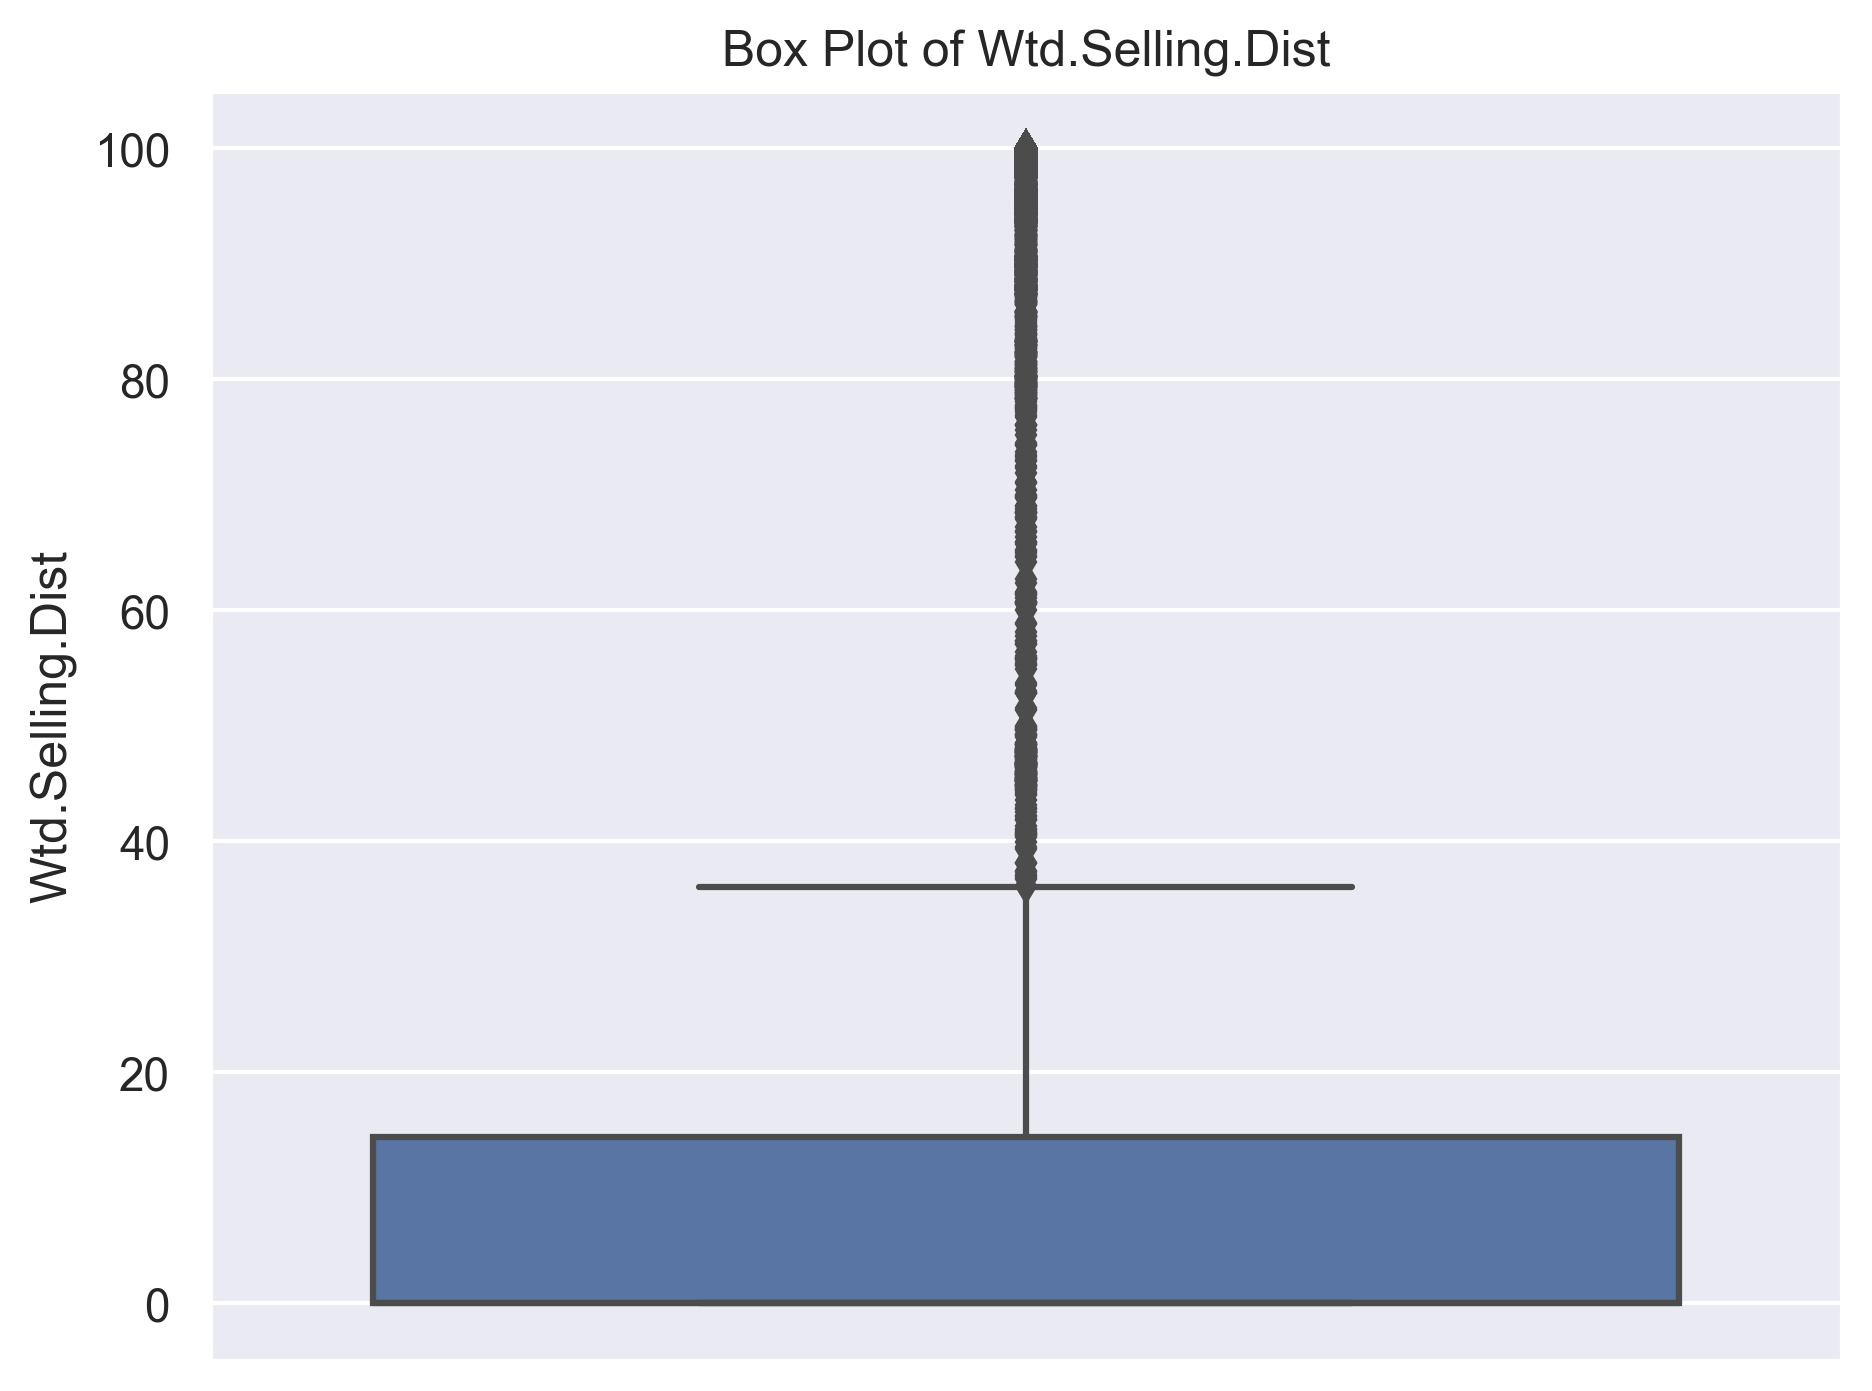

In [ ]:
sns.boxplot(y=df_inscope['Wtd.Selling.Dist'])
plt.title('Box Plot of Wtd.Selling.Dist')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Wtd_Selling_Dist.png")

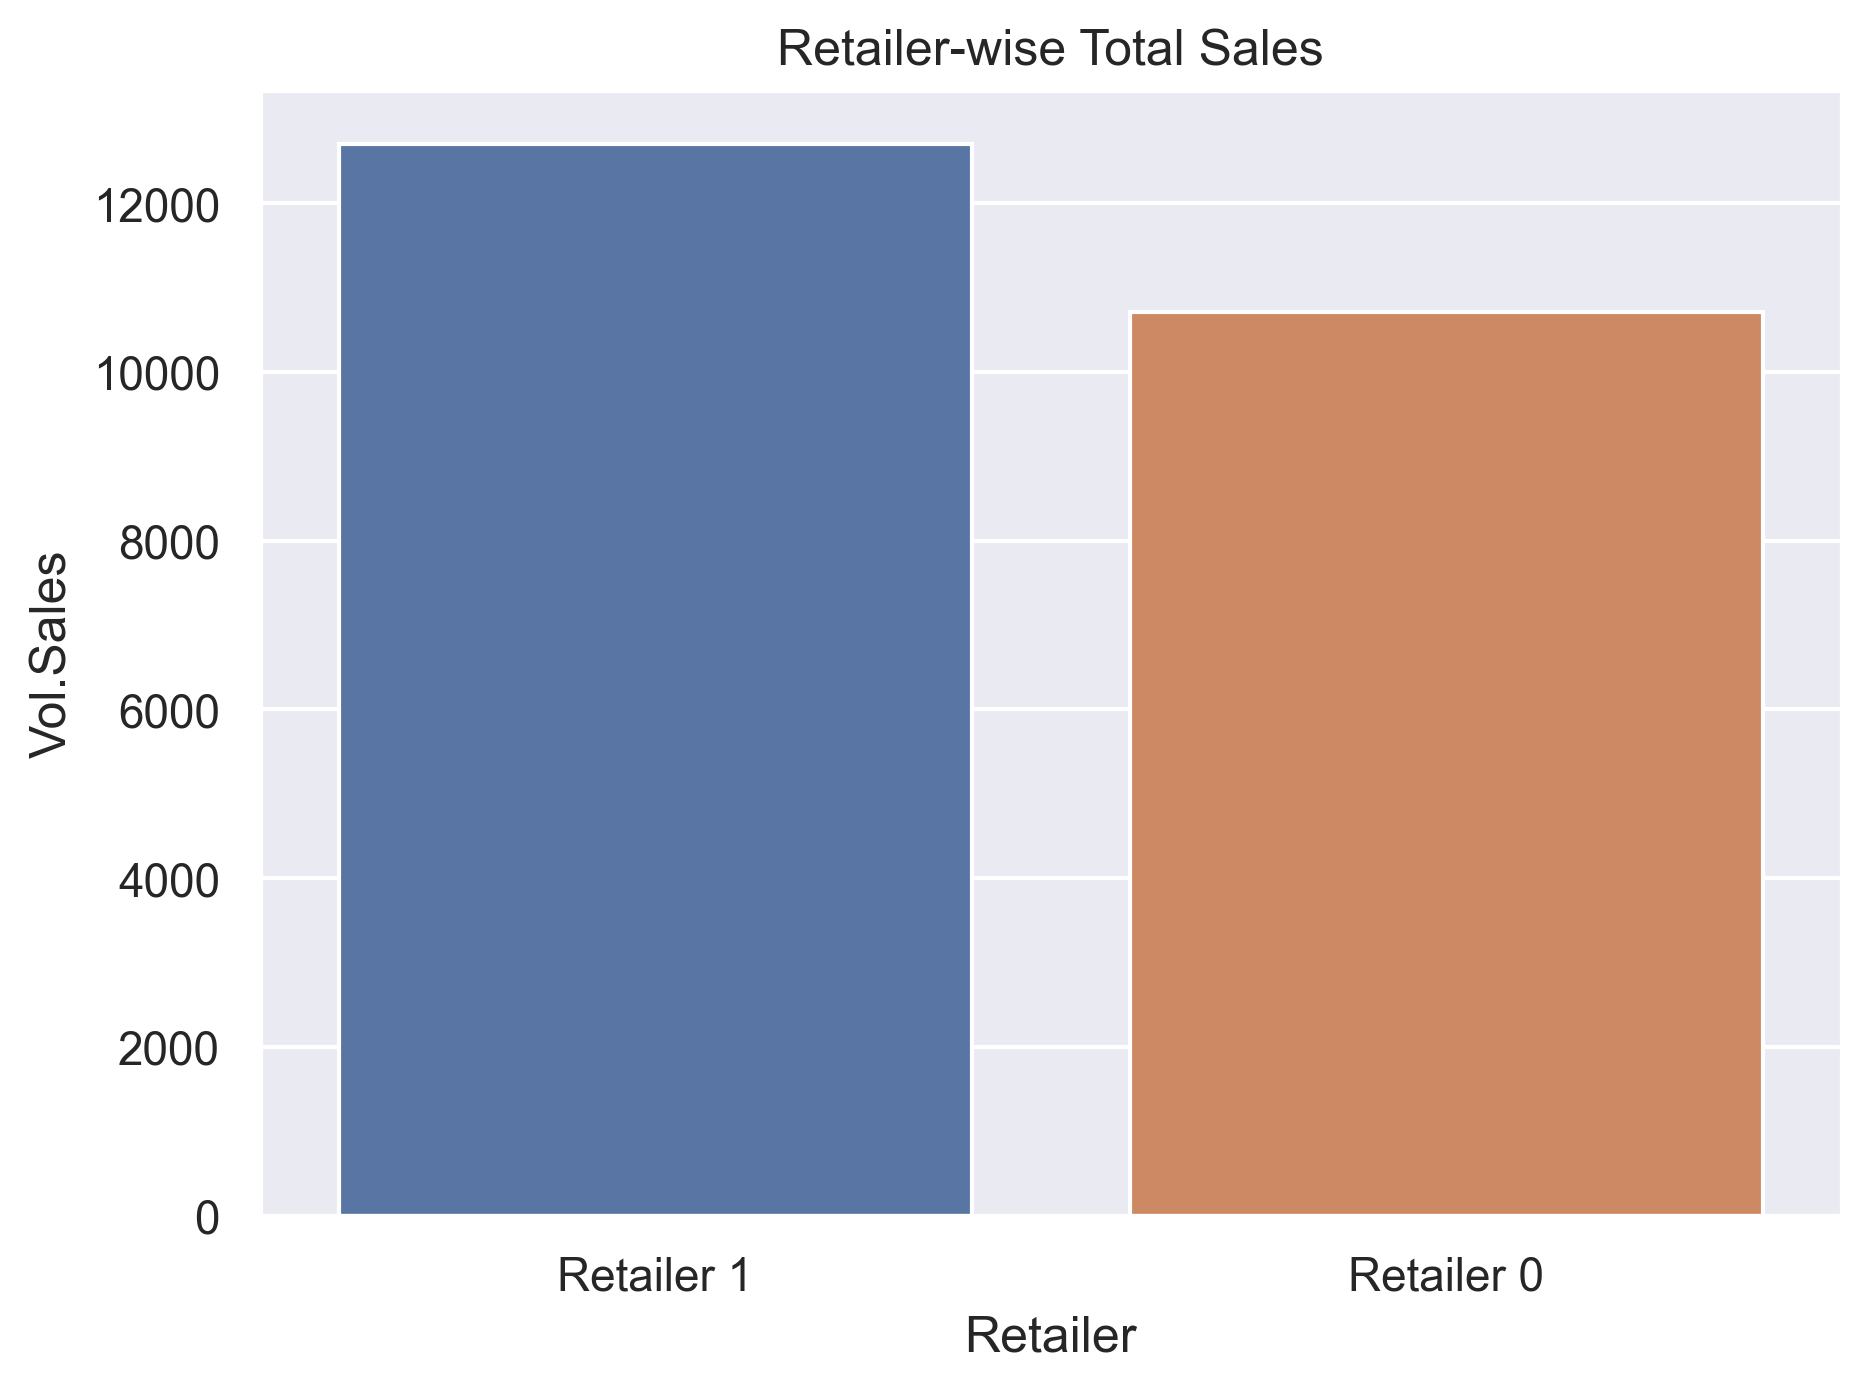

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['Retailer']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['Retailer'],temp['Vol.Sales'])
plt.title('Retailer-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Retailerwise_Total_Sales.png")

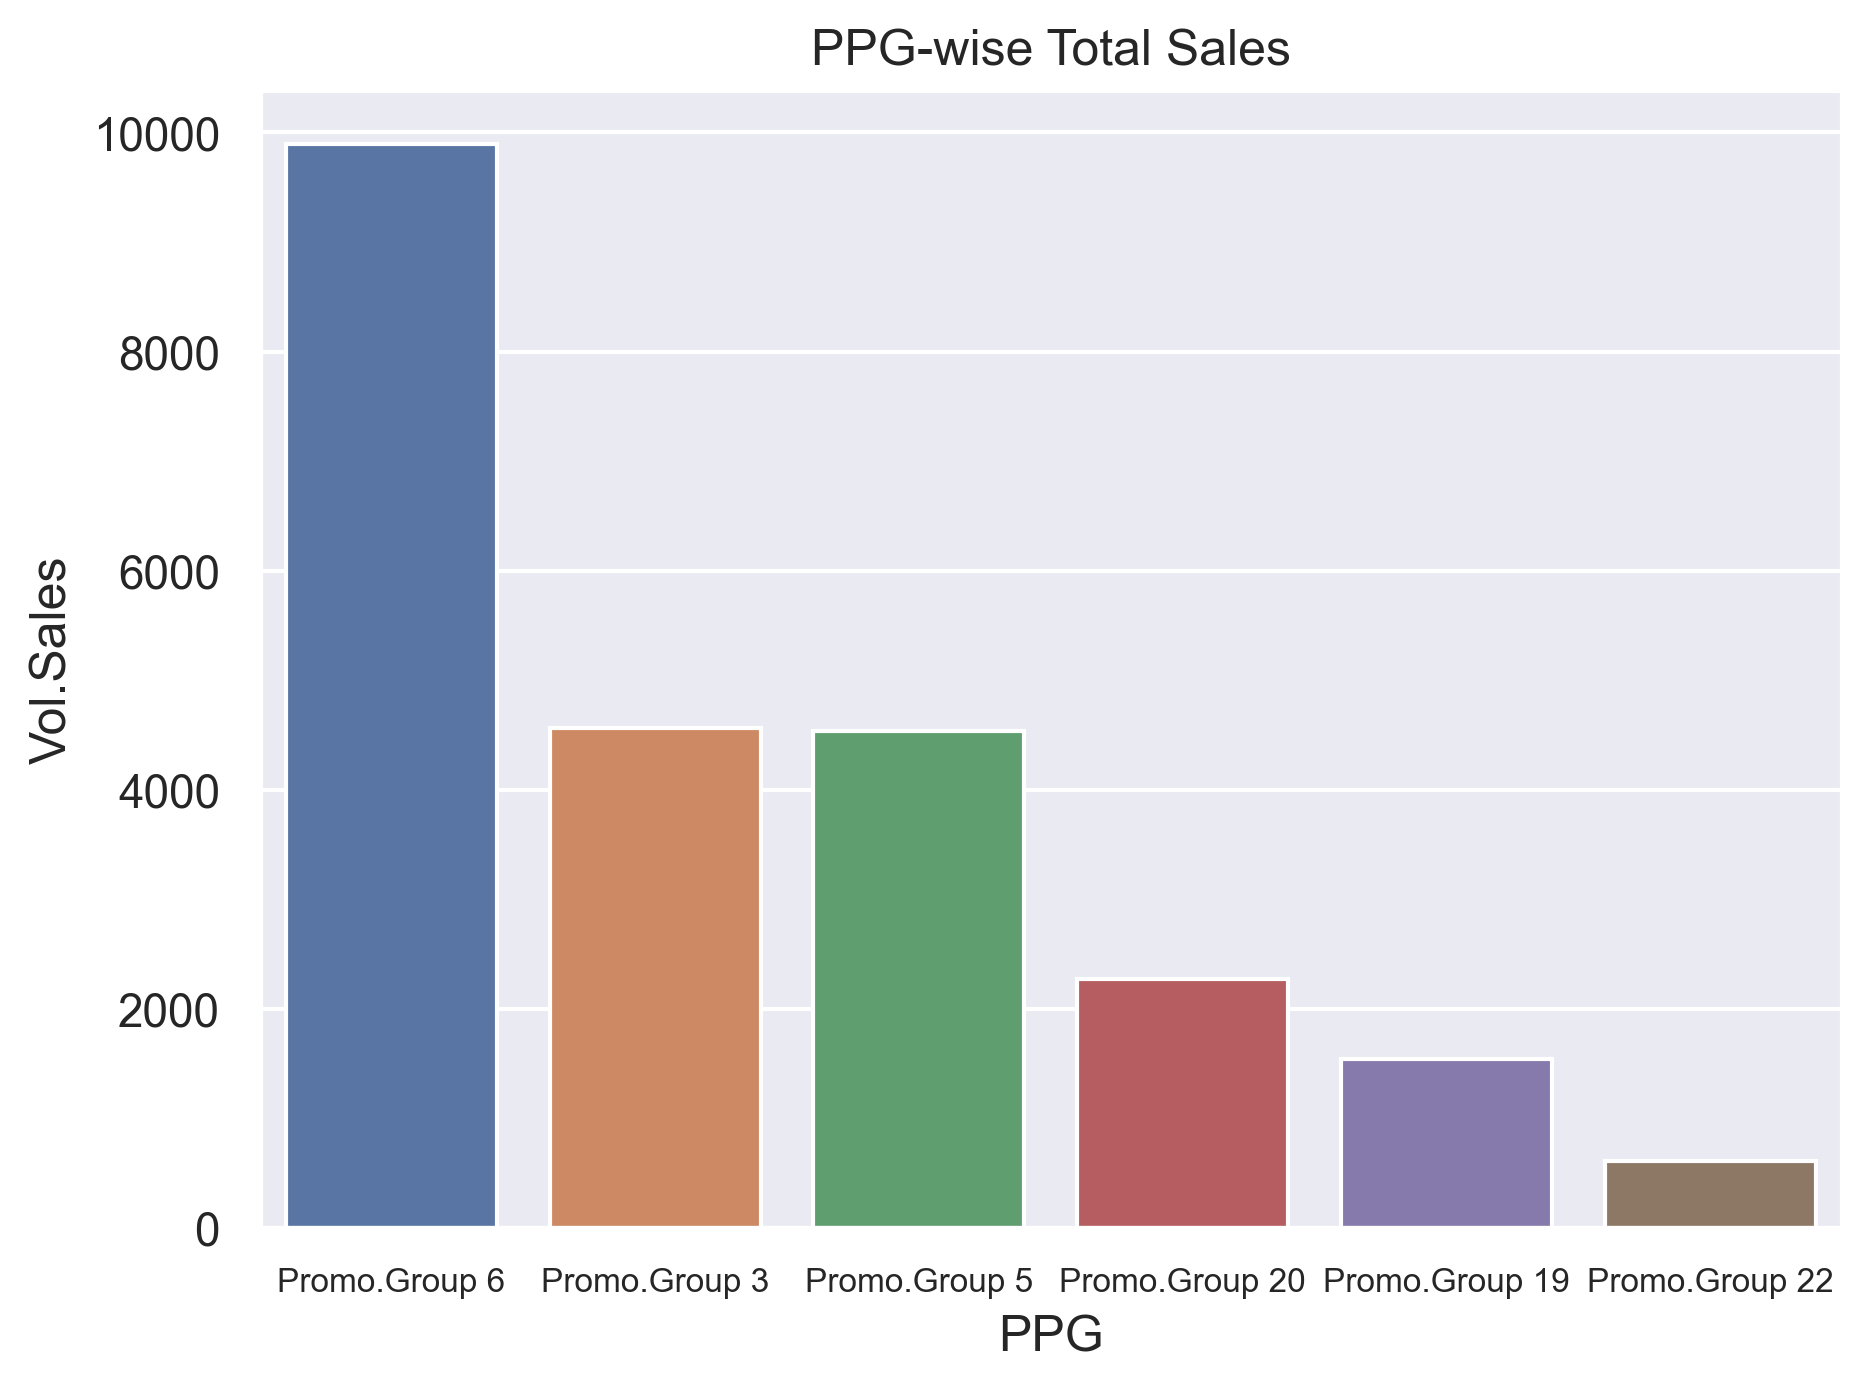

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['PPG']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['PPG'],temp['Vol.Sales'])
plt.xticks(rotation=0, fontsize=8)
plt.title('PPG-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\PPGwise_Total_Sales.png")

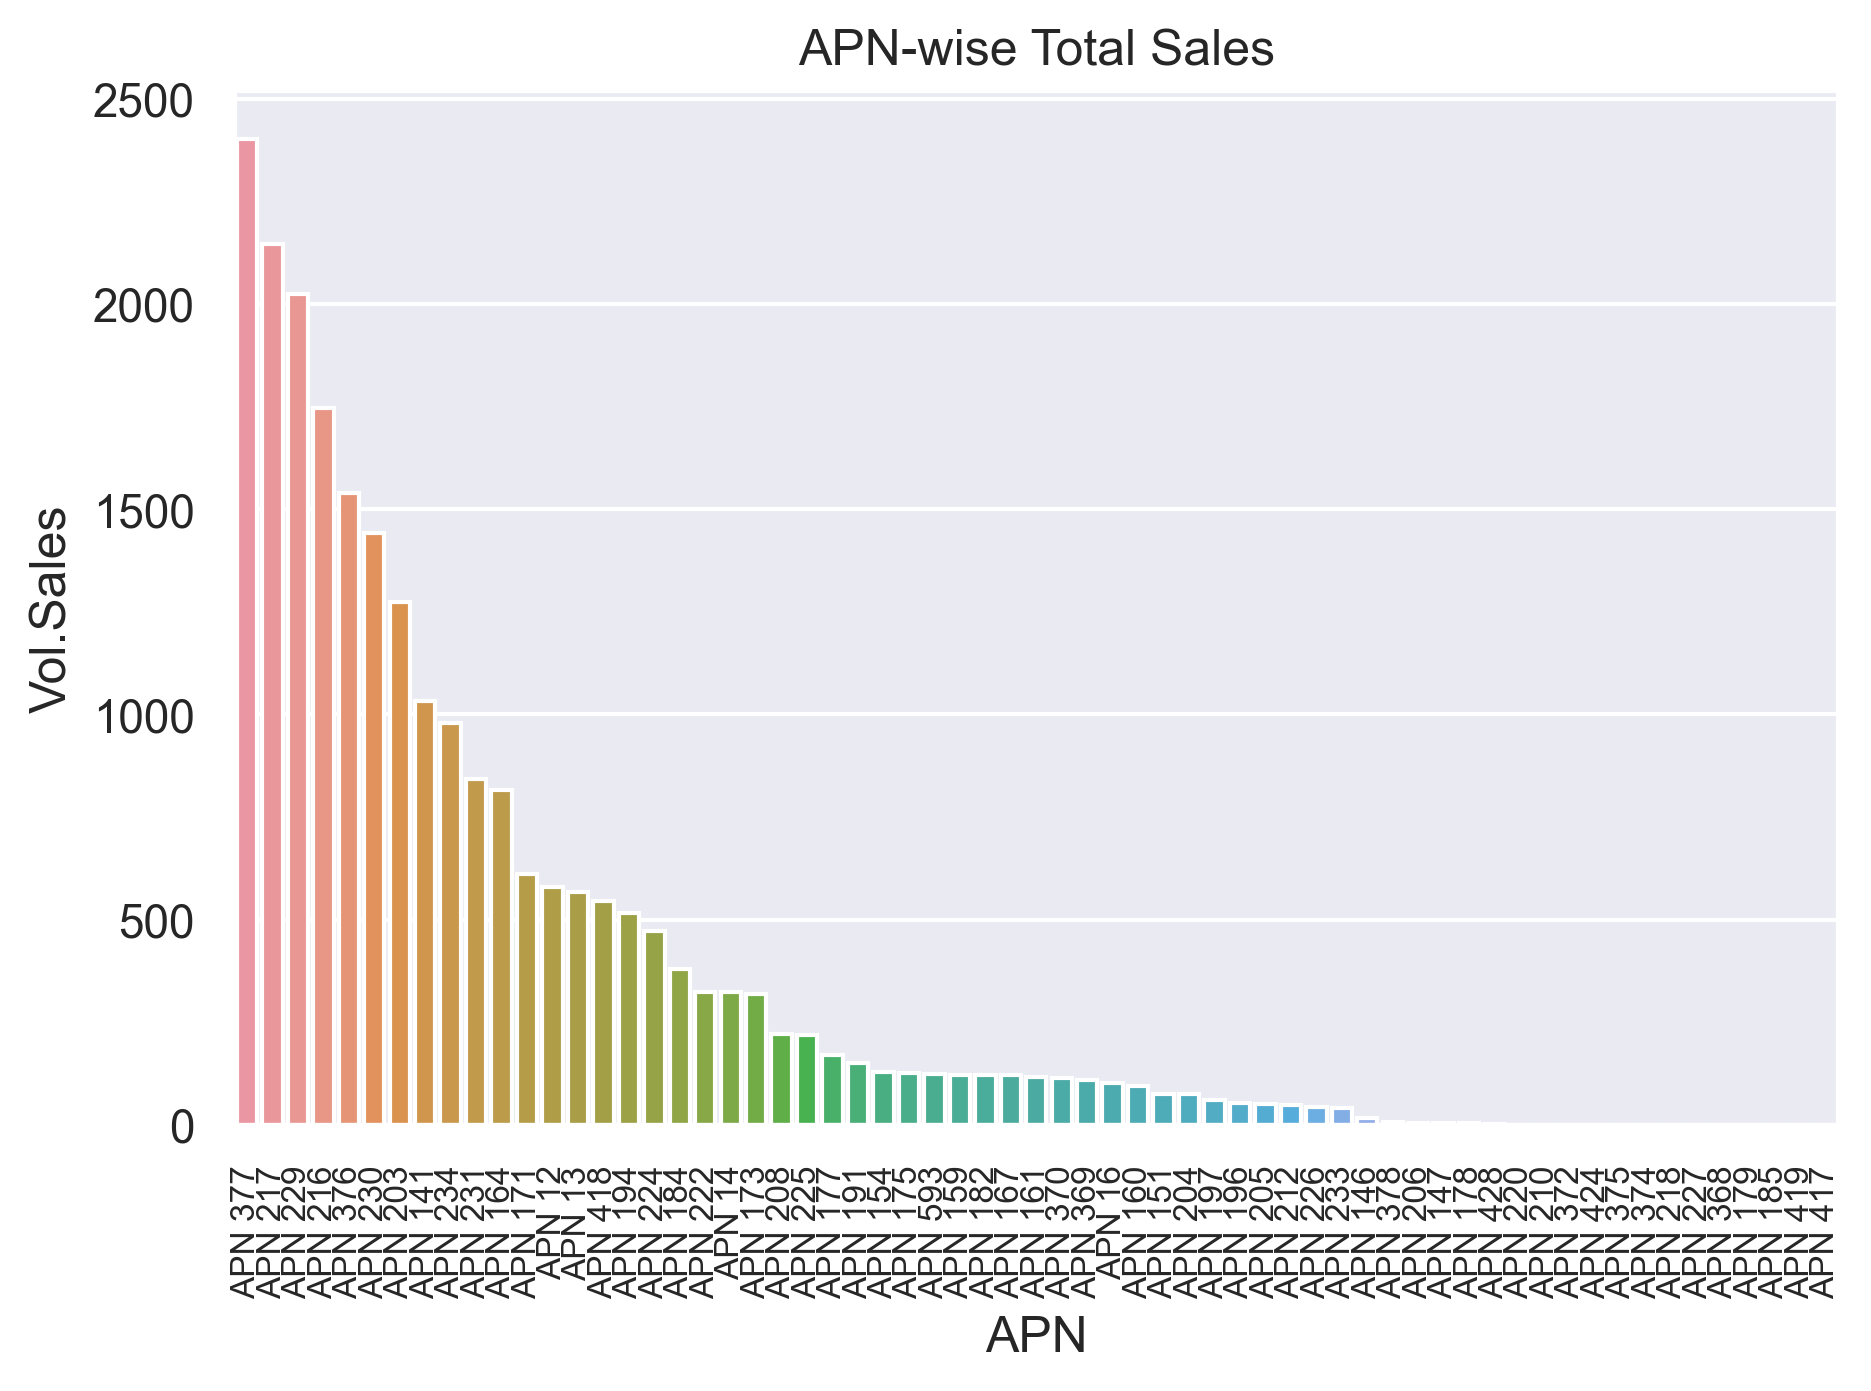

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['APN']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
temp = temp[temp['Vol.Sales'] > 0]
sns.barplot(temp['APN'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=8)
plt.title('APN-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\APNwise_Total_Sales.png")

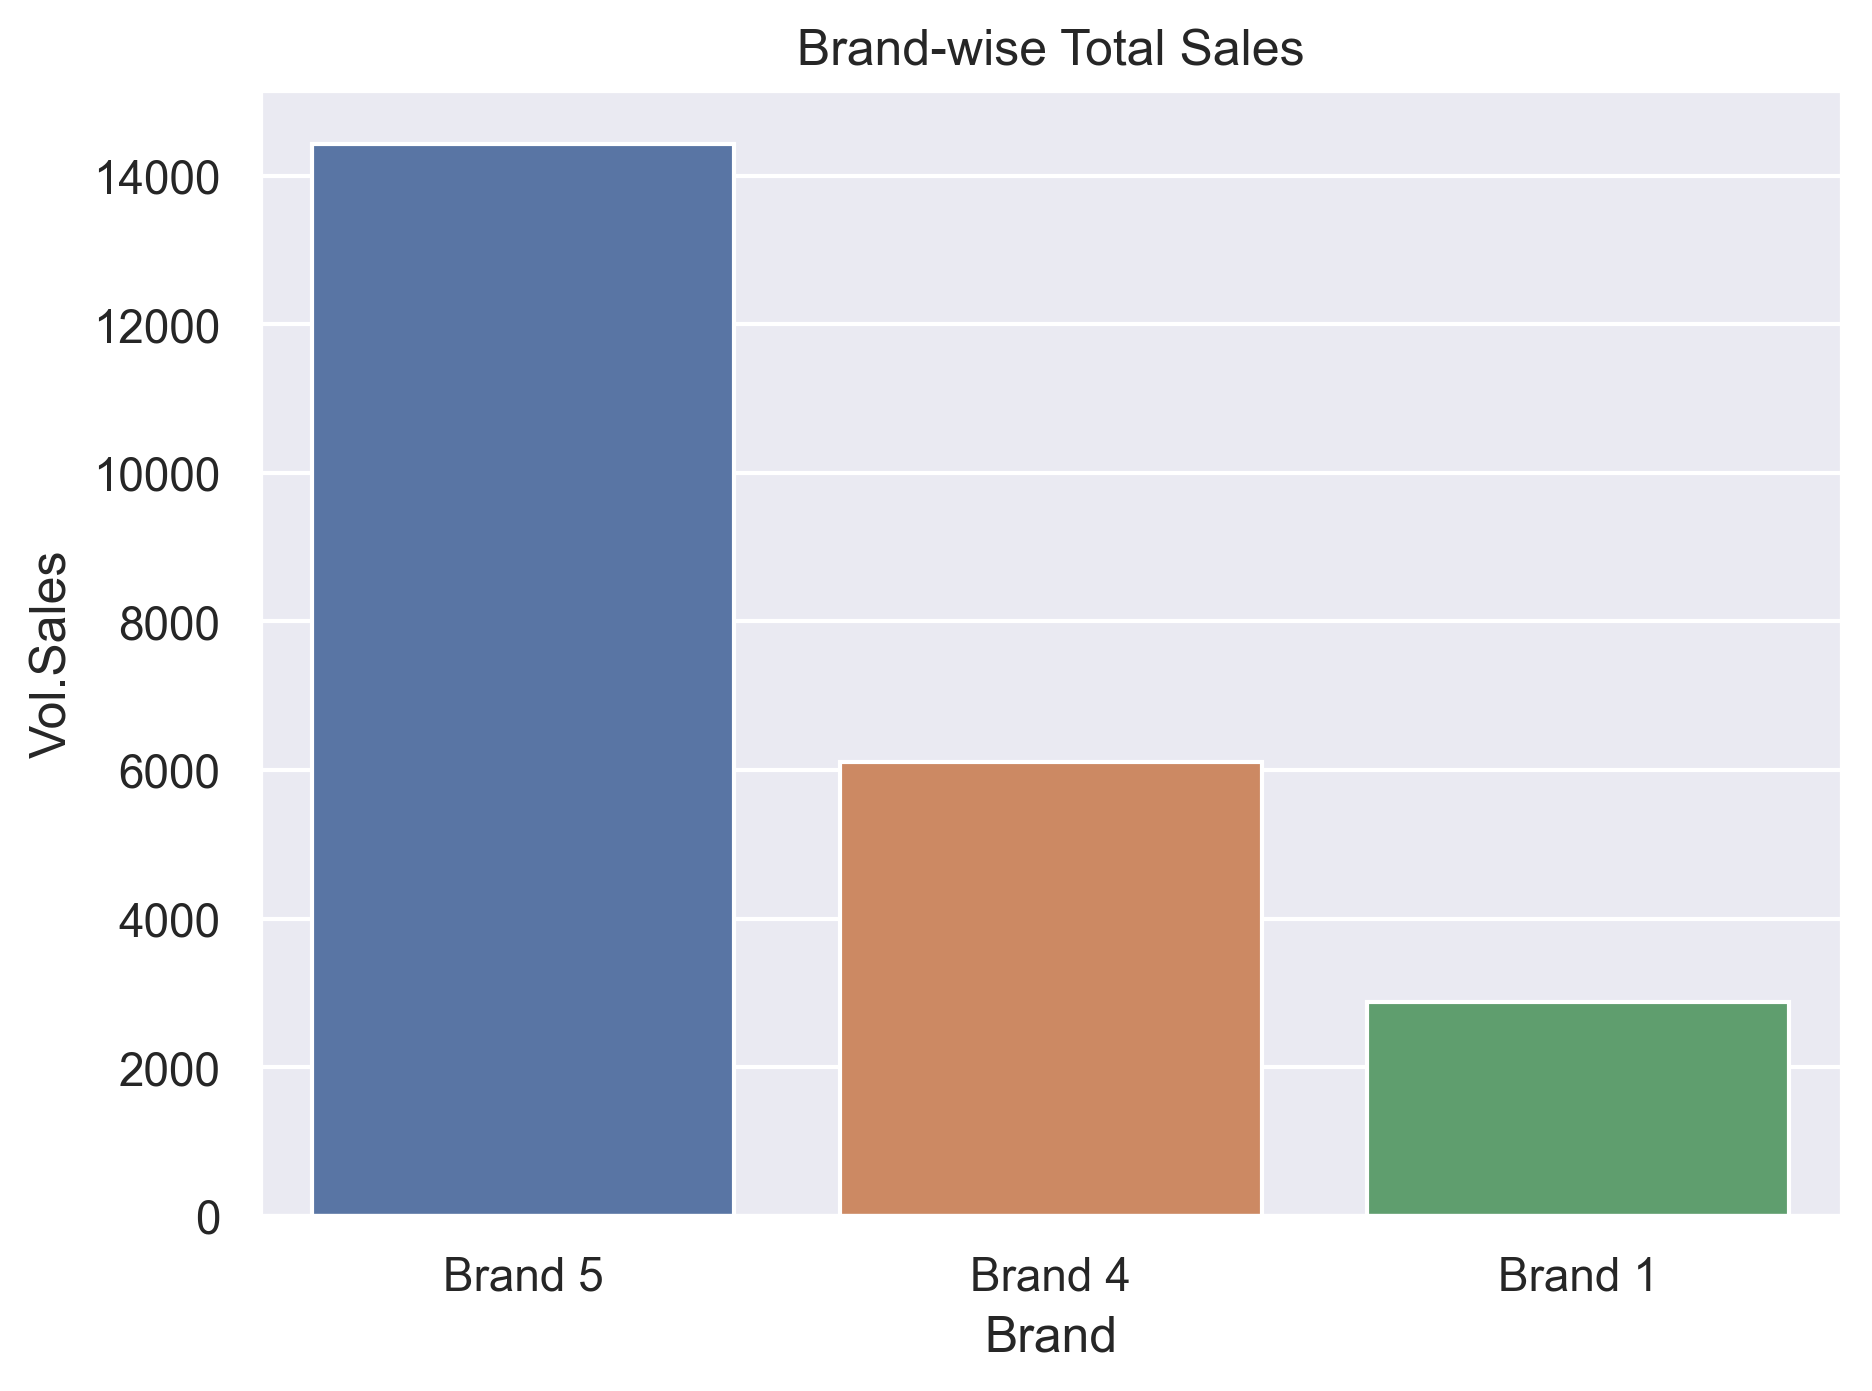

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['Brand']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['Brand'],temp['Vol.Sales'])
plt.title('Brand-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Total_Sales.png")

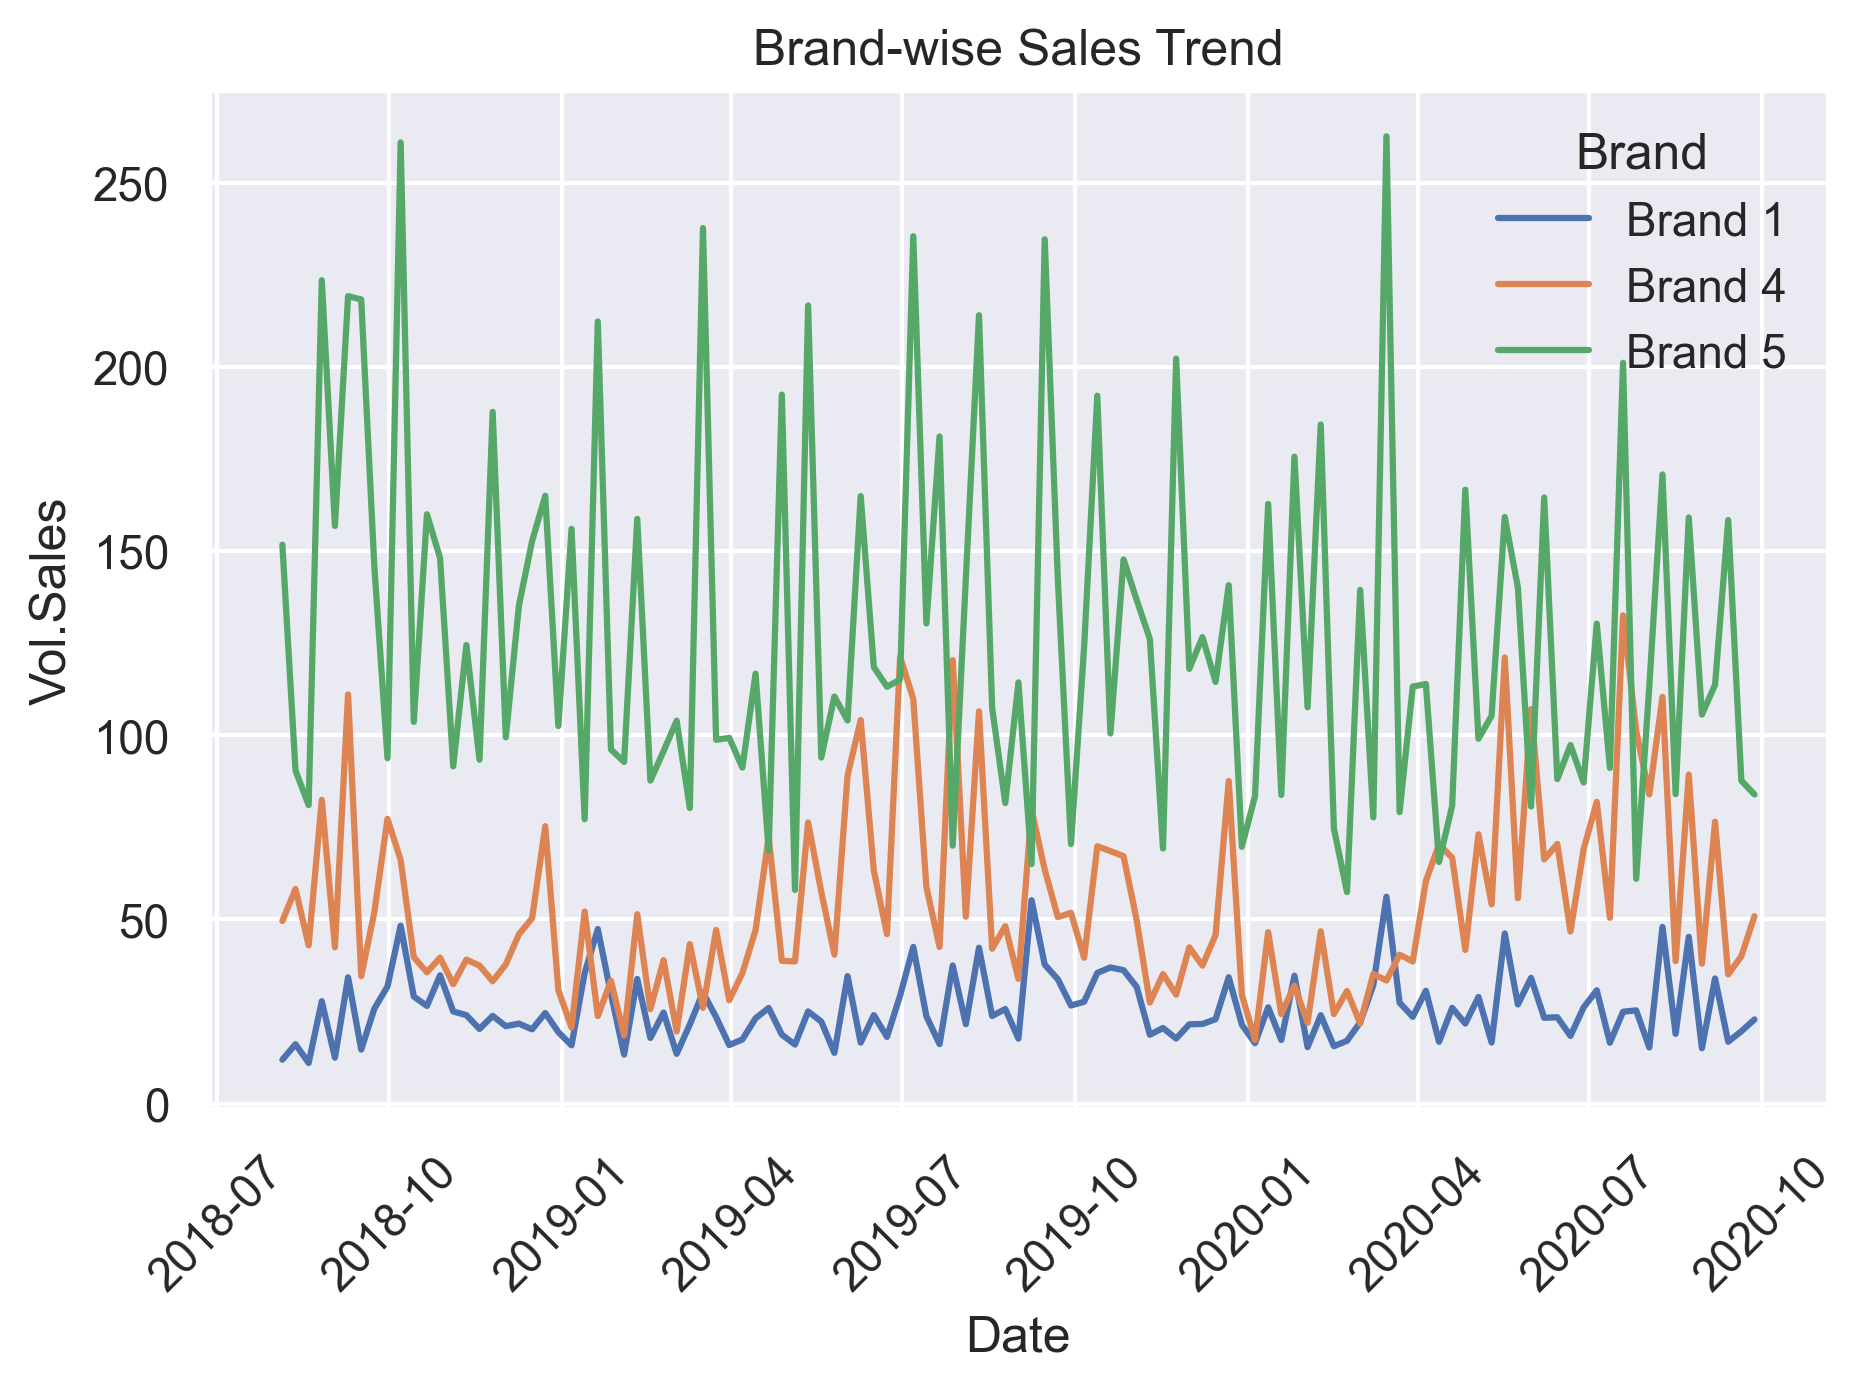

In [ ]:
temp = df_inscope.groupby(['Date','Brand']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Vol.Sales'],hue=temp['Brand'])
plt.xticks(rotation=45)
plt.title('Brand-wise Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Brandwise_Sales_Trend.png")

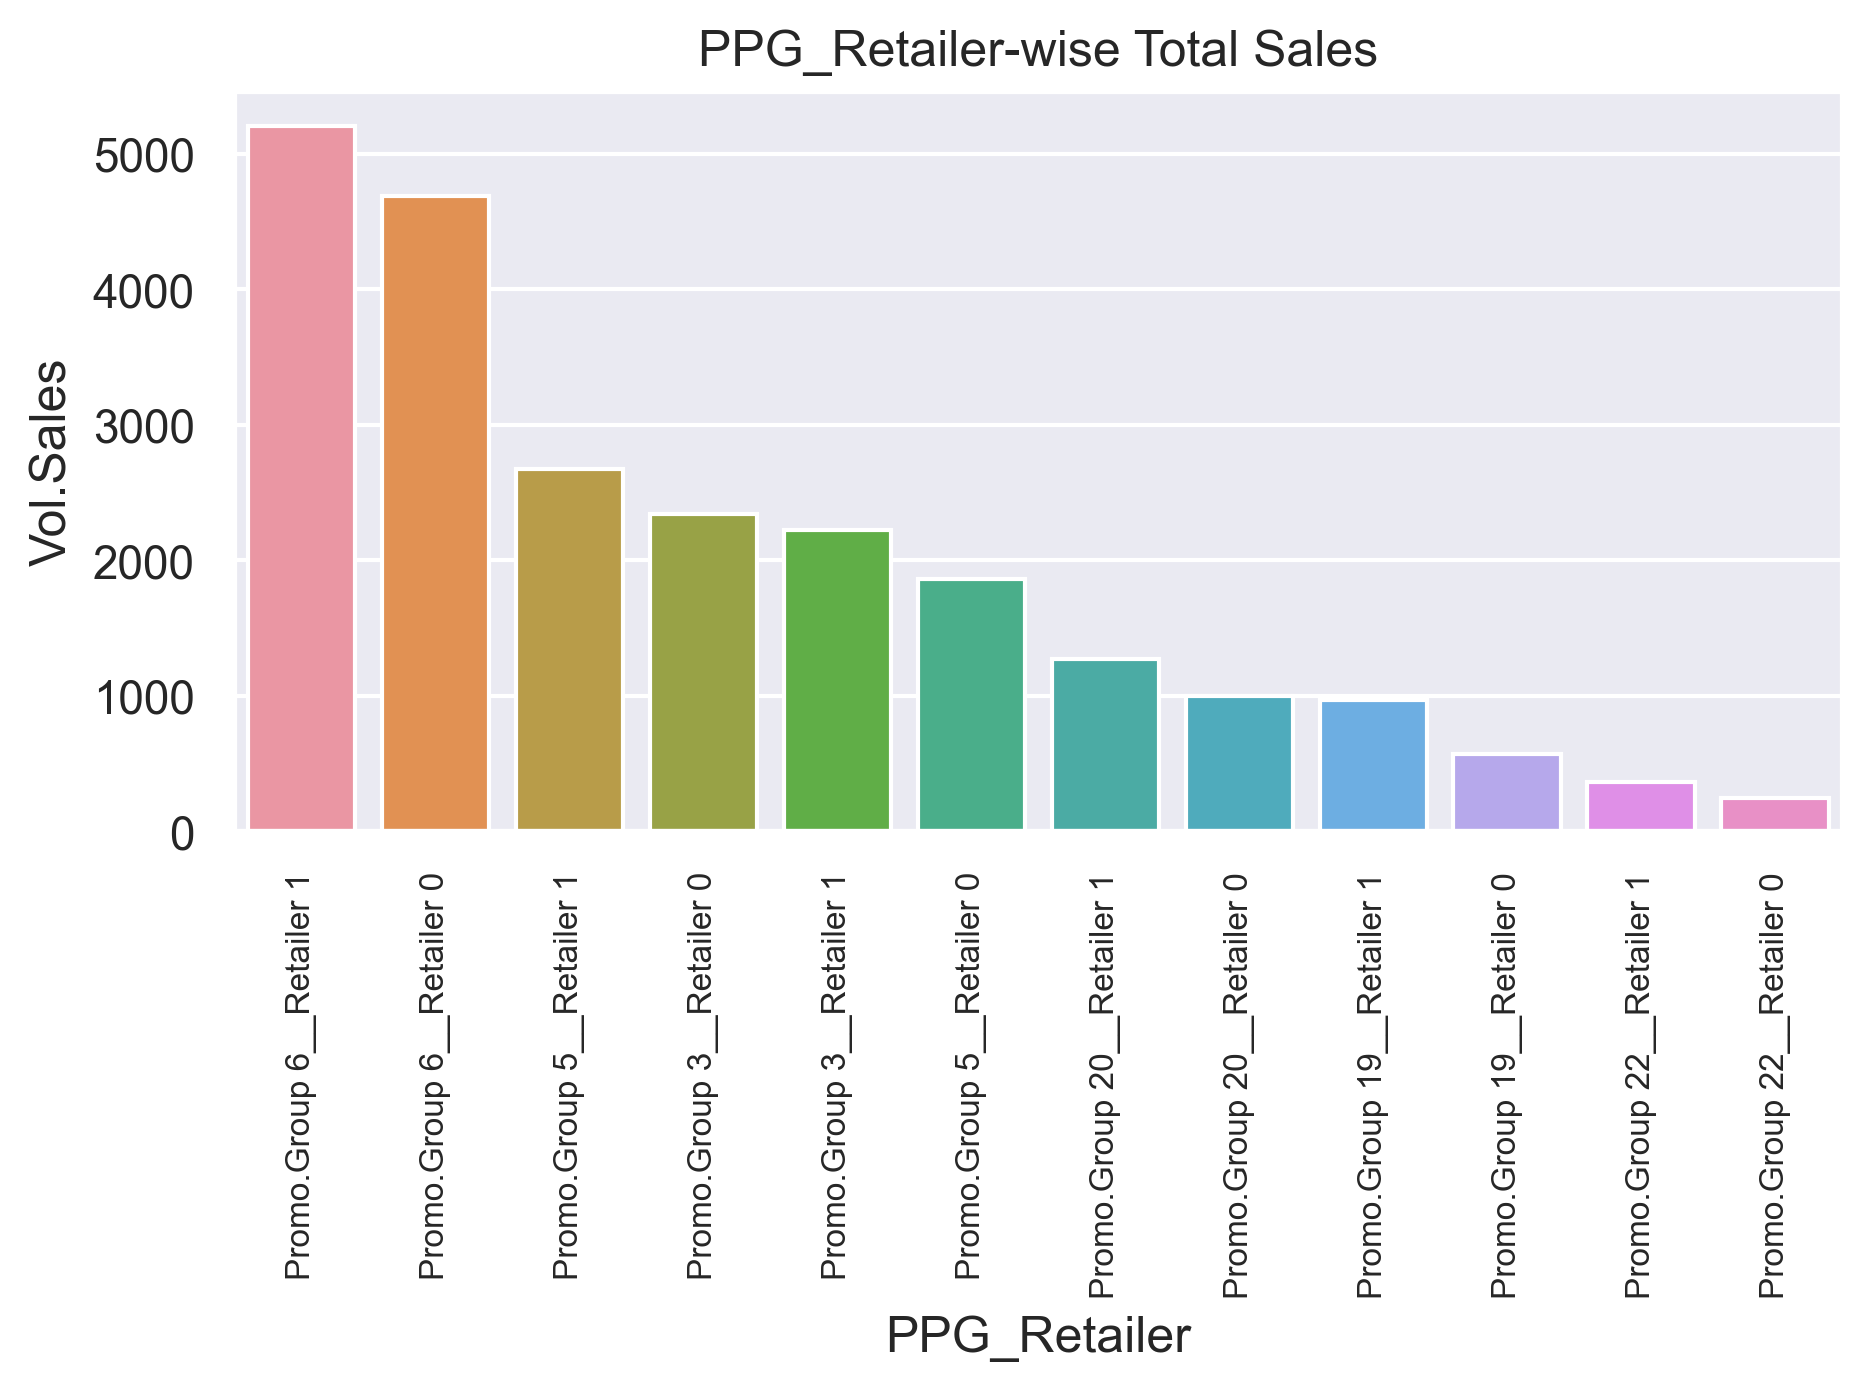

In [ ]:
temp = df_inscope.copy()
temp = temp.groupby(['PPG_Retailer']).agg({'Vol.Sales':'sum'}).reset_index()
temp.sort_values('Vol.Sales', inplace=True, ascending=False)
sns.barplot(temp['PPG_Retailer'],temp['Vol.Sales'])
plt.xticks(rotation=90, fontsize=8)
plt.title('PPG_Retailer-wise Total Sales')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\PPG_Retailerwise_Total_Sales.png")

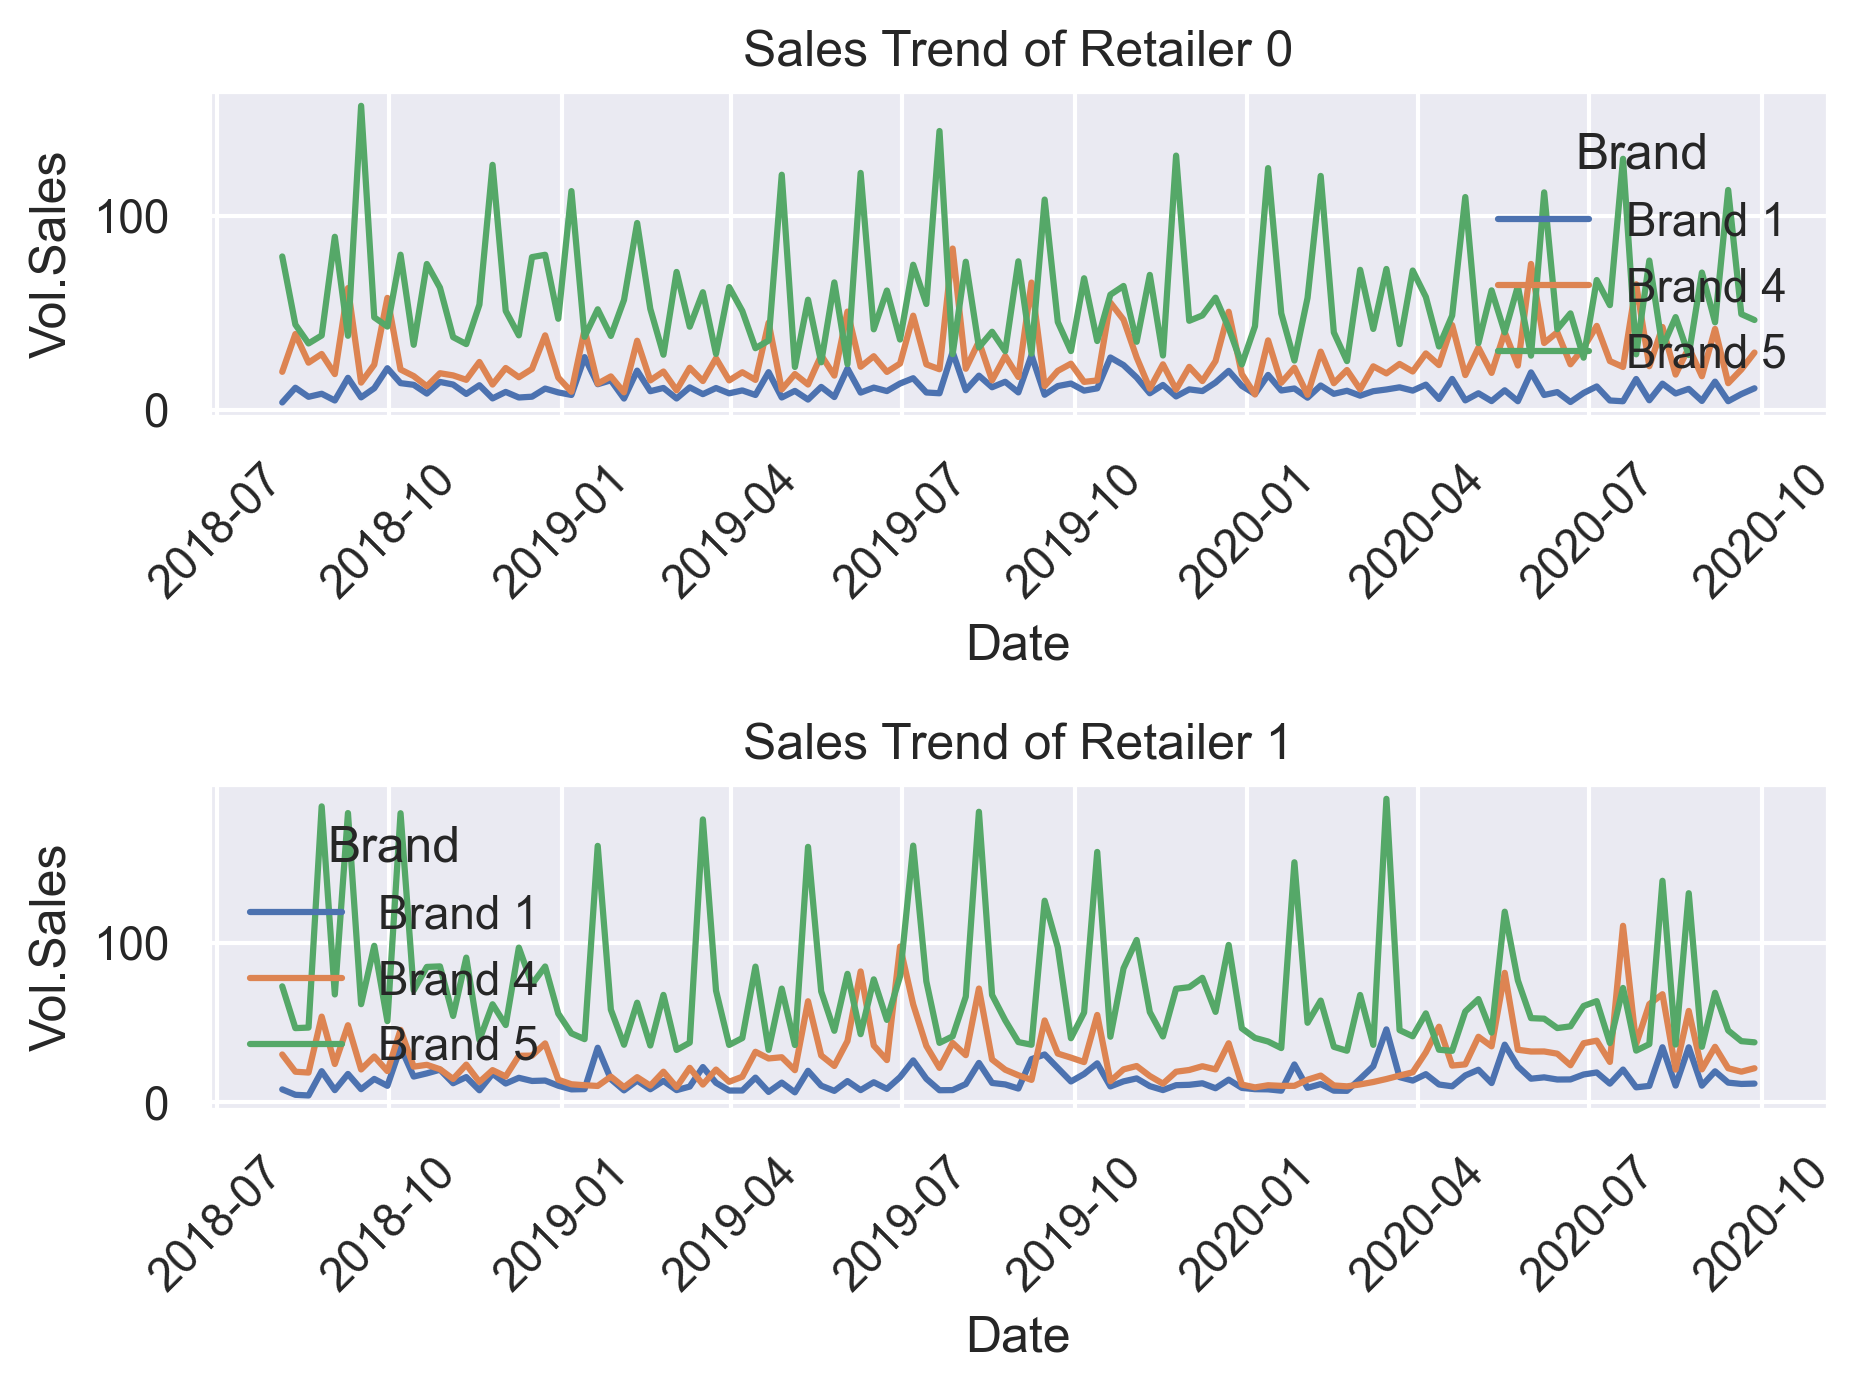

In [ ]:
temp = df_inscope.groupby(['Date','Retailer','Brand']).agg({'Vol.Sales':'sum'}).reset_index()

#Retailer 0:
plt.subplot(2, 1, 1)
temp1 = temp[temp.Retailer=='Retailer 0']
temp1.sort_values('Date', inplace=True)
sns.lineplot(x=temp1['Date'],y=temp1['Vol.Sales'],hue=temp1['Brand'])
plt.xticks(rotation=45)
plt.title('Sales Trend of Retailer 0');

#Retailer 1:
plt.subplot(2, 1, 2)
temp2 = temp[temp.Retailer=='Retailer 1']
temp2.sort_values('Date', inplace=True)
sns.lineplot(x=temp2['Date'],y=temp2['Vol.Sales'],hue=temp2['Brand'])
plt.xticks(rotation=45)
plt.title('Sales Trend of Retailer 1');

plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\Retailerwise_Brandwise_Sales_Trend.png")

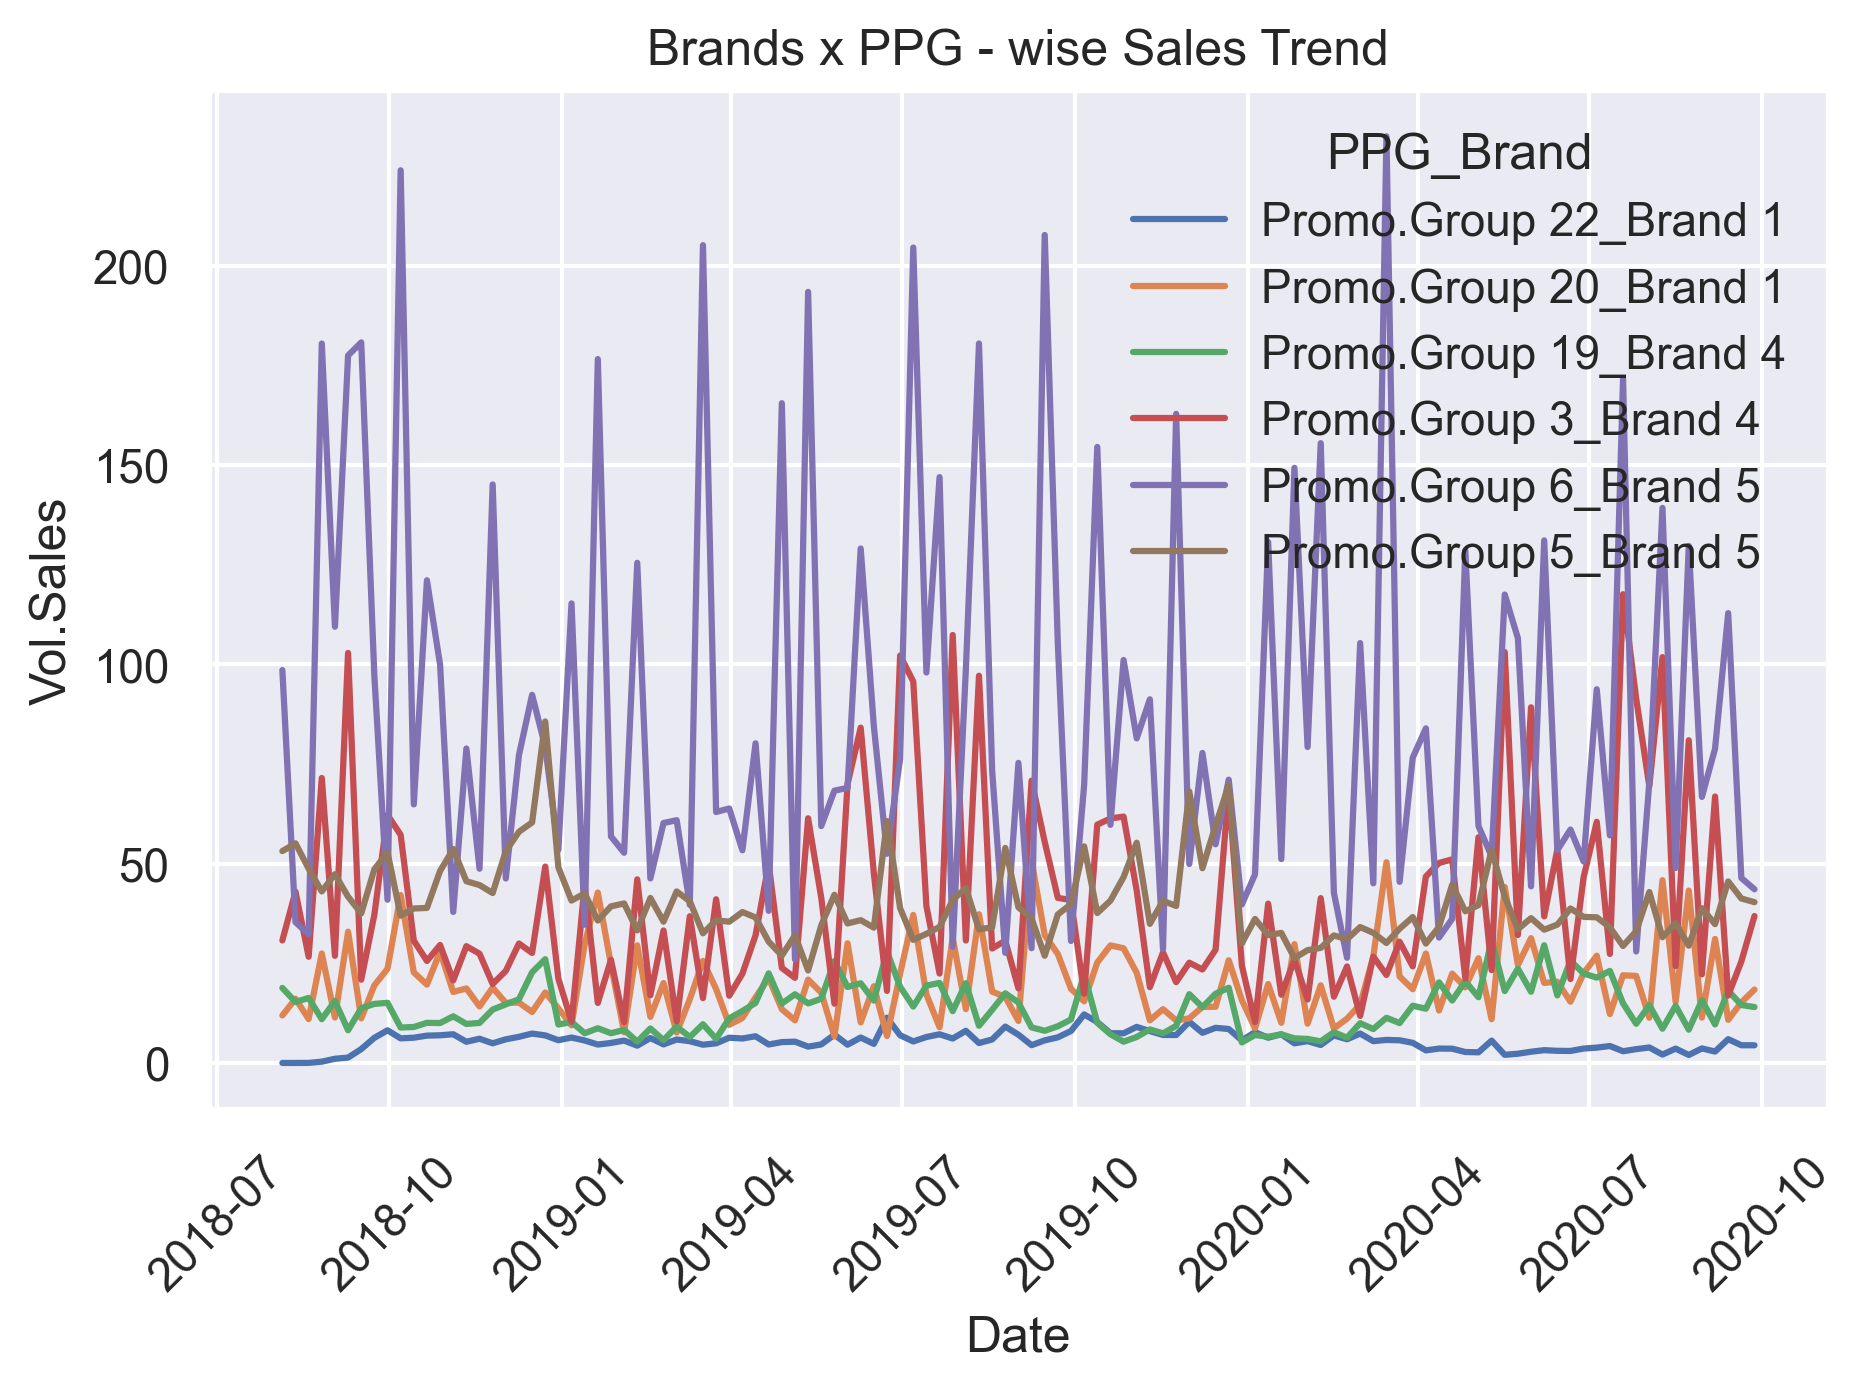

In [ ]:
temp = df_inscope.groupby(['Date','PPG','Brand']).agg({'Vol.Sales':'sum'}).reset_index().sort_values(by=['Vol.Sales'],ascending=[False])
temp['PPG_Brand'] = temp['PPG'] + '_' + temp['Brand']
temp.sort_values('Date', inplace=True)
sns.lineplot(x=temp['Date'],y=temp['Vol.Sales'],hue=temp['PPG_Brand'])
plt.xticks(rotation=45)
plt.title('Brands x PPG - wise Sales Trend')
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{eda_plots}\BrandsxPPG_wise_Sales_Trend.png")

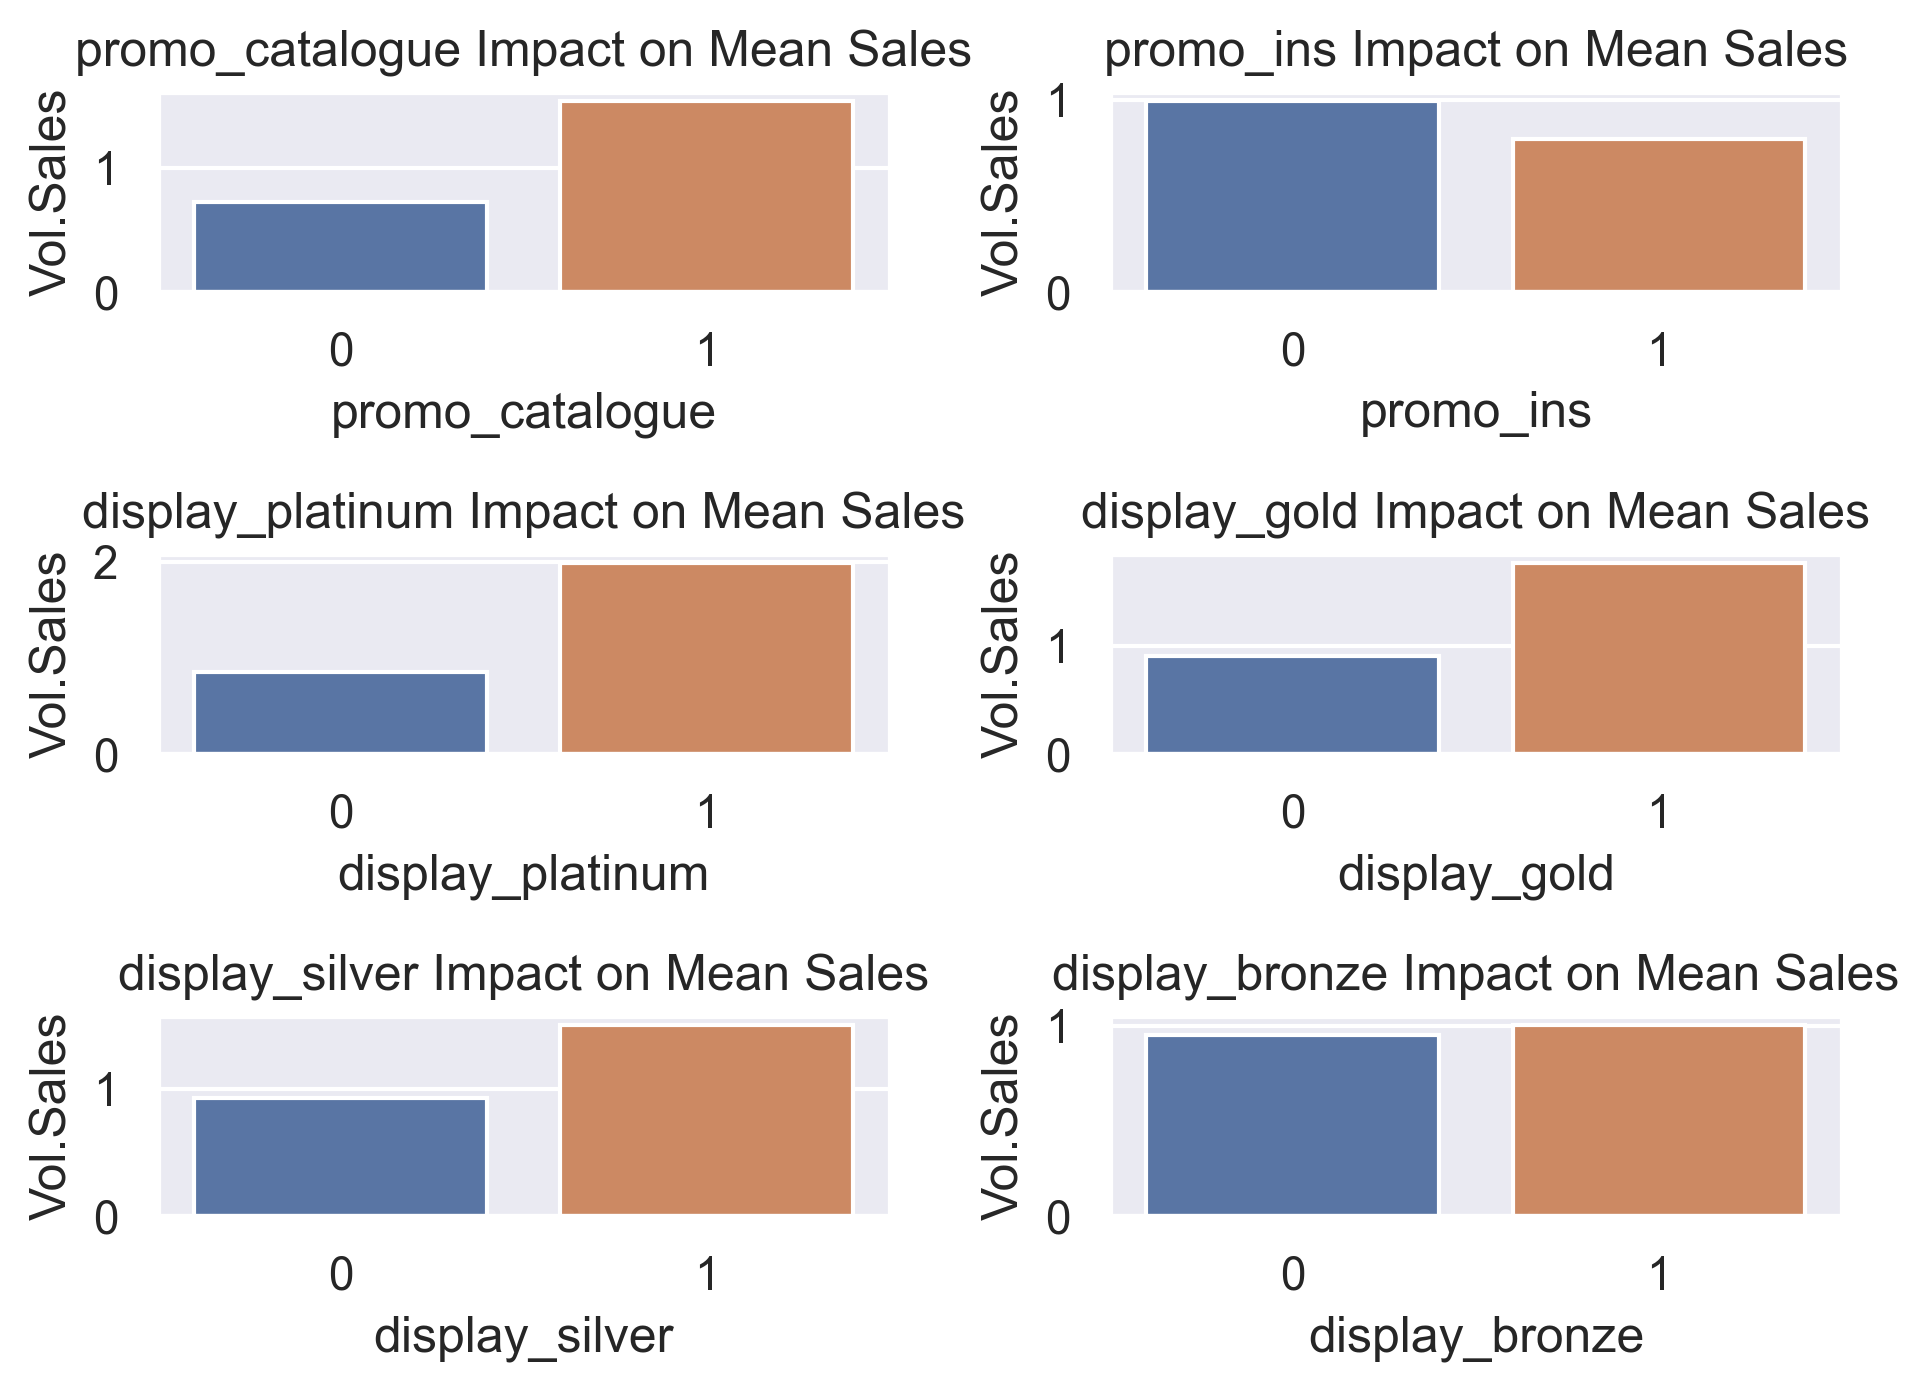

In [ ]:
for i in range(1, 7):
    plt.subplot(3,2,i)
    temp = df_inscope.copy()
    temp = temp.groupby(binary_cols[i-1]).agg({'Vol.Sales':'mean'}).reset_index()
    # temp.sort_values('Vol.Sales', inplace=True, ascending=False)
    sns.barplot(temp[binary_cols[i-1]],temp['Vol.Sales'])
    plt.title(f'{binary_cols[i-1]} Impact on Mean Sales');

plt.tight_layout();
if overwrite_permission:
    plt.savefig(f"{eda_plots}\Promotional_Activities_Impact_on_Mean_Sales.png")

### Sparsity

In [ ]:
# function to check 4 different types of sparsities (% of zeros) in the given dataset
def checking_sparsity_levels(df):

    n = df.shape[0]
    promo_sparsity = np.round(100 * (df[promo_cols].sum(axis=1) == 0).sum() / n, 2)
    display_sparsity = np.round(100 * (df[display_cols].sum(axis=1) == 0).sum() / n, 2)
    promotional_activity_sparsity = np.round(100 * (df[binary_cols].sum(axis=1) == 0).sum() / n, 2)
    sales_sparsity = np.round(100 * (df[target_feature] == 0).sum() / n, 2)

    return promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity

In [ ]:
print("The promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity are respectively")
checking_sparsity_levels(df_inscope)

The promo_sparsity, display_sparsity, promotional_activity_sparsity, sales_sparsity are respectively


(52.79, 65.07, 50.75, 70.72)

### Creating PPG x Retailer - wise datasets

In [ ]:
ppg_retailer = df_inscope['PPG_Retailer'].unique()

# creating the folder for datasets if it did not exist already
if ppg_retailer_raw_datasets not in os.listdir():
    os.mkdir(ppg_retailer_raw_datasets)

if overwrite_permission:
    for ppg_ret in ppg_retailer:
        temp = df_inscope[df_inscope['PPG_Retailer'] == ppg_ret]
        filepath = f"{ppg_retailer_raw_datasets}\{ppg_ret}.csv"
        temp.to_csv(filepath, index=False)

### Data Preprocessing and Feature Engineering

In [ ]:
# Loading the dependencies for data preprocessing and encoding

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

##### Exercise caution while modifying the following 2 cells

In [ ]:
# gathering features that needs to be dropped
remove_cols = ['PPG', 'Retailer', 'Sub.Segment', 'Sub.Brand', 'APN', 'Quarter', 'Year', 'Month_Year', 'PPG_Retailer', 'Vol.Sales']

# independent features to be used in the modelling
unprocessed_independent_features = [col for col in df_inscope.columns if col not in remove_cols]

print(f"The following independent features will be used --> {', '.join(unprocessed_independent_features)}")

The following independent features will be used --> Date, promo_catalogue, promo_ins, display_platinum, display_gold, display_silver, display_bronze, Segment, Brand, Packsize, Product.Type, Wtd.Selling.Dist, WeekNum, Month


In [ ]:
# column segregation for encoding

one_hot_encoding_cols = ['Segment', 'Brand', 'Product.Type']
target_encoding_cols = ['WeekNum', 'Month']

In [ ]:
# Function for data preprocessing

def data_preprocessing(df, normalize=True):

    df = df[unprocessed_independent_features + [target_feature]]
    print('Duplicates before groupby Date : ', df.duplicated(subset=unprocessed_independent_features).sum())
    df.groupby(by=unprocessed_independent_features).agg({target_feature:'sum'})
    df.drop(columns='Date', inplace=True)

    X = df[unprocessed_independent_features[1:]]
    y = df[target_feature]

    print('Duplicates after groupby Date : ', X.duplicated().sum())

    # performing one-hot encoding
    X = pd.get_dummies(data=X, columns=one_hot_encoding_cols, drop_first=True)

    # performing the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # create a TargetEncoder instance
    encoder = TargetEncoder(cols=target_encoding_cols, return_df=True)

    # fit and transform the training data
    X_train = encoder.fit_transform(X_train, y_train)

    # transforming the testing data
    X_test = encoder.transform(X_test)

    processed_independent_features = X_train.columns # capturing the column names before we lose them in the following transformation

    if normalize:
        # creating a normalizer
        norm = MinMaxScaler()

        # fitting and transforming on the training data
        X_train = norm.fit_transform(X_train)

        # transforming on the testing data
        X_test = norm.transform(X_test)


    X_processed = np.vstack([X_train, X_test])
    y_processed = y_train.append(y_test, ignore_index=True)
    df_processed = pd.DataFrame(X_processed, columns=processed_independent_features)
    df_processed[target_feature] = y_processed

    return X_train, X_test, y_train, y_test, processed_independent_features, df_processed

In [ ]:
# Loading the dependencies

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [ ]:
def training_evaluation_and_weights(X_train, X_test, y_train, y_test, model):

    # learning from the training dataset
    model.fit(X_train, y_train)

    # predicting the test data
    y_test_pred = model.predict(X_test)

    # performance on the training set
    train_metric = model.score(X_train, y_train)

    # performance on the test set
    test_metric = r2_score(y_test, y_test_pred)

    # the coefficients and the constant term are
    weights, bias = model.coef_, model.intercept_

    if isinstance(bias, np.ndarray):
        bias = bias[0]

    current_row = [dataset[:-4], modelname, train_metric, test_metric, *weights, bias]

    model_coeffs = pd.DataFrame()
    model_coeffs['features'] = feature_list
    model_coeffs['coeffs'] = weights
    model_coeffs['|coeffs|'] = np.abs(model_coeffs['coeffs'])
    model_coeffs.sort_values('|coeffs|', ascending=False, inplace=True)
    topfeat = list(model_coeffs['features'].values[:topK])

    current_row.append(', '.join(topfeat))

    return current_row, weights, bias

In [ ]:
# Can extend the list to accomadate other parametric models

models = {'LinearRegression' : LinearRegression(n_jobs=-1),
          'SGDRegression' : SGDRegressor(),
          'LassoRegression' : LassoCV(alphas=np.logspace(-4,2,100), cv=5, n_jobs=-1),
          'RidgeRegression' : RidgeCV(alphas=np.logspace(-4,2,100), cv=5)}

if impose_positive_constraint:
    positive_models = {'LinearRegression_Positive' : LinearRegression(positive=impose_positive_constraint, n_jobs=-1),
                       'LassoRegression_Positive' : LassoCV(alphas=np.logspace(-4,2,100), cv=5, positive=impose_positive_constraint, n_jobs=-1),
                       'ElasticNetRegression_Positive' : ElasticNetCV(l1_ratio=np.logspace(-10,0,21), alphas=np.logspace(-4,2,100), cv=5,
                                                             positive=impose_positive_constraint, n_jobs=-1)}

    models.update(positive_models)

The feature list of all the different datasets need not be same. For instance, they can vary particularly w.r.t to 'Segment' and 'Product.Type'

In [ ]:
# creating the necessary folders if it did not exist already
if ppg_retailer_processed_datasets not in os.listdir():
    os.mkdir(ppg_retailer_processed_datasets)
if ppg_retailer_metrics_weights not in os.listdir():
    os.mkdir(ppg_retailer_metrics_weights)
if ppg_retailer_contributions not in os.listdir():
    os.mkdir(ppg_retailer_contributions)
if ppg_retailer_contributions_percent not in os.listdir():
    os.mkdir(ppg_retailer_contributions_percent)
if final_report_folder not in os.listdir():
    os.mkdir(final_report_folder)

##### Exercise caution if you are modifying the following cell

In [ ]:
all_models_performance = list()  # to save the performance and details of the dataset on which the model is trained
all_models_relative_contribution_of_promotional_activity = list() # to save the relative percent contribution of 6 promotional activities

# iterating over all the dataset variants
for dataset in os.listdir(ppg_retailer_raw_datasets):

    df = pd.read_csv(f"{ppg_retailer_raw_datasets}\{dataset}", parse_dates=['Date'])
    sparsities = checking_sparsity_levels(df)
    X_train, X_test, y_train, y_test, feature_list, df_processed = data_preprocessing(df) # processing the data ready for modelling
    print(f'In the dataset {dataset[:-4]}, Dates are continuous : ', checking_Data_continuity(df), '\n')
    if overwrite_permission:
        df_processed.to_csv(f"{ppg_retailer_processed_datasets}\{dataset[:-4]}_Processed.csv", index=False) # saving the processed datasets

    current_model_details = list()
    current_model_columns = ['PPG_Retailer_Variant', 'Model', 'Train_r2', 'Test_r2', *feature_list, 'Constant', f'Top{topK}_most_important_features']
    current_model_contribution_percent = list()

    # iterating over all the model variants
    for modelname in models.keys():
        model = models[modelname]
        current_row, weights, bias = training_evaluation_and_weights(X_train, X_test, y_train, y_test, model) # model training
        current_model_details.append(current_row)
        all_models_performance.append(current_row[:4] + [*df_processed.shape, *sparsities])

        # calculating the contributions
        df_contribute = pd.DataFrame(df_processed.drop(columns=target_feature) * weights, columns=feature_list)
        df_contribute['Constant'] = bias
        df_contribute['y_pred'] = df_contribute.sum(axis=1)
        df_contribute['y_true'] = df_processed[target_feature]
        df_contribute.insert(loc=0, column='Model', value=modelname)

        contribution_percent = np.round(100 * df_contribute.drop(columns=['Model', 'y_pred', 'y_true']).sum() / df_contribute['y_pred'].sum(), 2)
        current_model_contribution_percent.append([modelname, *contribution_percent])

        relative_contribution = np.round(100 * df_contribute[binary_cols].sum() / df_contribute[binary_cols].sum().sum(), 2)
        relative_contribution = [dataset[:-4], modelname, *relative_contribution]
        all_models_relative_contribution_of_promotional_activity.append(relative_contribution)

        if overwrite_permission:
            df_contribute.to_csv(f"{ppg_retailer_contributions}\{dataset[:-4]}__{modelname}.csv" , index=False)

    # creating a csv for each variant of PPGxRetailer which has the report of all the models
    current_model_details = pd.DataFrame(current_model_details, columns=current_model_columns)
    current_model_contribution_percent = pd.DataFrame(current_model_contribution_percent, columns=['Model', *feature_list, 'Constant'])

    if overwrite_permission:
        current_model_details.to_csv(f"{ppg_retailer_metrics_weights}\{dataset[:-4]}__Metrics&Weights.csv", index=False)
        current_model_contribution_percent.to_csv(f"{ppg_retailer_contributions_percent}\{dataset[:-4]}__contribution_percent.csv", index=False)

# consolidation of all the models across different variants of PPGxRetailer
all_models_performance = pd.DataFrame(all_models_performance, columns=current_model_columns[:4] + ['NumRows', 'NumCols'] + \
                                     ['Promo_sparsity', 'Display_sparsity', 'Promotional_activity_sparsity', 'Sales_sparsity'])
all_models_relative_contribution_of_promotional_activity = pd.DataFrame(all_models_relative_contribution_of_promotional_activity,\
                                                                       columns=['PPG_Retailer_Variant', 'Model'] + binary_cols)

if overwrite_permission:
    all_models_performance.to_csv(f"{final_report_folder}\All_Models_Performance.csv", index=False)
    all_models_relative_contribution_of_promotional_activity.to_csv(f"{final_report_folder}\All_Models_Relative_Contribution.csv", index=False)

Duplicates before groupby Date :  113
Duplicates after groupby Date :  221
In the dataset Promo.Group 19__Retailer 0, Dates are continuous :  True 

Duplicates before groupby Date :  113
Duplicates after groupby Date :  197
In the dataset Promo.Group 19__Retailer 1, Dates are continuous :  True 

Duplicates before groupby Date :  570
Duplicates after groupby Date :  666
In the dataset Promo.Group 20__Retailer 0, Dates are continuous :  True 

Duplicates before groupby Date :  594
Duplicates after groupby Date :  643
In the dataset Promo.Group 20__Retailer 1, Dates are continuous :  True 

Duplicates before groupby Date :  0
Duplicates after groupby Date :  1
In the dataset Promo.Group 22__Retailer 0, Dates are continuous :  True 

Duplicates before groupby Date :  0
Duplicates after groupby Date :  7
In the dataset Promo.Group 22__Retailer 1, Dates are continuous :  True 

Duplicates before groupby Date :  2066
Duplicates after groupby Date :  2474
In the dataset Promo.Group 3__Retaile

In [ ]:
all_models_performance

,PPG_Retailer_Variant,Model,Train_r2,Test_r2,NumRows,NumCols,Promo_sparsity,Display_sparsity,Promotional_activity_sparsity,Sales_sparsity
0,Promo.Group 19__Retailer 0,LinearRegression,0.805070,0.751686,565,12,79.65,99.12,79.65,80.00
1,Promo.Group 19__Retailer 0,SGDRegression,0.796594,0.801566,565,12,79.65,99.12,79.65,80.00
2,Promo.Group 19__Retailer 0,LassoRegression,0.804164,0.769206,565,12,79.65,99.12,79.65,80.00
3,Promo.Group 19__Retailer 0,RidgeRegression,0.804222,0.767851,565,12,79.65,99.12,79.65,80.00
4,Promo.Group 19__Retailer 0,LinearRegression_Positive,0.804969,0.754410,565,12,79.65,99.12,79.65,80.00
...,...,...,...,...,...,...,...,...,...,...
79,Promo.Group 6__Retailer 1,LassoRegression,0.389330,0.431085,3500,12,40.71,61.06,40.71,61.06
80,Promo.Group 6__Retailer 1,RidgeRegression,0.388995,0.434715,3500,12,40.71,61.06,40.71,61.06
81,Promo.Group 6__Retailer 1,LinearRegression_Positive,0.389380,0.430894,3500,12,40.71,61.06,40.71,61.06
82,Promo.Group 6__Retailer 1,LassoRegression_Positive,0.389380,0.430912,3500,12,40.71,61.06,40.71,61.06


In [ ]:
all_models_relative_contribution_of_promotional_activity

,PPG_Retailer_Variant,Model,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze
0,Promo.Group 19__Retailer 0,LinearRegression,2.57,94.85,0.00,0.00,0.00,2.57
1,Promo.Group 19__Retailer 0,SGDRegression,2.05,95.90,0.00,0.00,0.00,2.05
2,Promo.Group 19__Retailer 0,LassoRegression,0.00,100.00,0.00,0.00,0.00,0.00
3,Promo.Group 19__Retailer 0,RidgeRegression,2.60,94.81,0.00,0.00,0.00,2.60
4,Promo.Group 19__Retailer 0,LinearRegression_Positive,0.00,94.11,0.00,0.00,0.00,5.89
...,...,...,...,...,...,...,...,...
79,Promo.Group 6__Retailer 1,LassoRegression,48.51,16.07,17.99,8.87,4.97,3.59
80,Promo.Group 6__Retailer 1,RidgeRegression,48.96,16.26,17.95,8.69,4.63,3.51
81,Promo.Group 6__Retailer 1,LinearRegression_Positive,46.13,15.78,18.80,9.37,5.47,4.45
82,Promo.Group 6__Retailer 1,LassoRegression_Positive,46.31,15.80,18.73,9.33,5.44,4.39


In [ ]:
#Picking the best performing model for each PPG X Retailer
best_r2_index = all_models_performance[all_models_performance.Model.str.endswith('_Positive')].groupby(['PPG_Retailer_Variant'])['Test_r2'].idxmax()
best_performing_models = all_models_performance.loc[best_r2_index]
best_performing_models.reset_index(drop=True, inplace=True)
best_performing_models

,PPG_Retailer_Variant,Model,Train_r2,Test_r2,NumRows,NumCols,Promo_sparsity,Display_sparsity,Promotional_activity_sparsity,Sales_sparsity
0,Promo.Group 19__Retailer 0,LassoRegression_Positive,0.804295,0.767371,565,12,79.65,99.12,79.65,80.00
1,Promo.Group 19__Retailer 1,LassoRegression_Positive,0.794474,0.857922,565,12,92.92,73.45,71.68,79.29
2,Promo.Group 20__Retailer 0,LinearRegression_Positive,0.587503,0.479924,1688,13,60.13,72.57,60.13,60.55
3,Promo.Group 20__Retailer 1,LassoRegression_Positive,0.573664,0.499510,1689,13,38.01,61.10,38.01,59.15
4,Promo.Group 22__Retailer 0,ElasticNetRegression_Positive,0.765630,0.402084,113,12,82.30,99.12,82.30,12.39
5,Promo.Group 22__Retailer 1,LassoRegression_Positive,0.772602,0.368151,113,12,94.69,74.34,74.34,4.42
6,Promo.Group 3__Retailer 0,LassoRegression_Positive,0.302071,0.242863,5078,12,53.07,61.93,53.07,80.37
7,Promo.Group 3__Retailer 1,LinearRegression_Positive,0.429582,0.271279,5080,12,40.75,63.74,39.86,90.00
8,Promo.Group 5__Retailer 0,LinearRegression_Positive,0.730259,0.708229,1240,13,77.02,96.45,77.02,65.00
9,Promo.Group 5__Retailer 1,LassoRegression_Positive,0.706411,0.705593,1242,13,92.91,69.00,68.12,61.03


In [ ]:
best_models_relative_contribution_of_promotional_activity = pd.merge(best_performing_models[['PPG_Retailer_Variant','Model']],all_models_relative_contribution_of_promotional_activity,how='left',on=['PPG_Retailer_Variant','Model'])

if overwrite_permission:
    best_performing_models.to_csv(f"{final_report_folder}\Best_Performing_Models.csv", index=False)
    best_models_relative_contribution_of_promotional_activity.to_csv(f"{final_report_folder}\Best_Models_Relative_Contribution.csv", index=False)

In [ ]:
best_models_relative_contribution_of_promotional_activity

,PPG_Retailer_Variant,Model,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze
0,Promo.Group 19__Retailer 0,LassoRegression_Positive,0.00,100.00,0.00,0.00,0.00,0.00
1,Promo.Group 19__Retailer 1,LassoRegression_Positive,100.00,0.00,0.00,0.00,0.00,0.00
2,Promo.Group 20__Retailer 0,LinearRegression_Positive,0.00,20.44,45.77,3.24,22.28,8.27
3,Promo.Group 20__Retailer 1,LassoRegression_Positive,66.37,22.09,11.54,0.00,0.00,0.00
4,Promo.Group 22__Retailer 0,ElasticNetRegression_Positive,50.02,0.00,0.00,0.00,0.00,49.98
5,Promo.Group 22__Retailer 1,LassoRegression_Positive,97.82,0.00,0.00,0.00,0.00,2.18
6,Promo.Group 3__Retailer 0,LassoRegression_Positive,63.82,6.46,23.11,0.00,6.61,0.00
7,Promo.Group 3__Retailer 1,LinearRegression_Positive,47.39,11.35,28.31,2.16,3.12,7.67
8,Promo.Group 5__Retailer 0,LinearRegression_Positive,21.65,78.35,0.00,0.00,0.00,0.00
9,Promo.Group 5__Retailer 1,LassoRegression_Positive,53.02,0.00,24.83,0.00,0.00,22.15


In [ ]:
# Metrics barplot for various models
df1 = best_performing_models[['PPG_Retailer_Variant','Train_r2']]
df1['Train/Test'] = 'Train'
df2 = best_performing_models[['PPG_Retailer_Variant','Test_r2']]
df2['Train/Test'] = 'Test'
df2.rename(columns={'Test_r2':'Train_r2'},inplace=True)
temp = df1.append(df2)
temp.rename(columns={'Train_r2':'r2_Score'},inplace=True)
sns.barplot(x='PPG_Retailer_Variant',y='r2_Score',data=temp,hue='Train/Test')
plt.xticks(rotation=90, fontsize=5)
plt.xticks(fontsize=7)
plt.yticks(fontsize=8)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=8)
plt.title('Model Metrics',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    plt.savefig(f"{final_report_folder}\Model_metrics.png")

In [ ]:
model_dict = best_performing_models.set_index('PPG_Retailer_Variant')['Model'].to_dict()
model_dict

{'Promo.Group 19__Retailer 0': 'LassoRegression_Positive',
 'Promo.Group 19__Retailer 1': 'LassoRegression_Positive',
 'Promo.Group 20__Retailer 0': 'LinearRegression_Positive',
 'Promo.Group 20__Retailer 1': 'LassoRegression_Positive',
 'Promo.Group 22__Retailer 0': 'ElasticNetRegression_Positive',
 'Promo.Group 22__Retailer 1': 'LassoRegression_Positive',
 'Promo.Group 3__Retailer 0': 'LassoRegression_Positive',
 'Promo.Group 3__Retailer 1': 'LinearRegression_Positive',
 'Promo.Group 5__Retailer 0': 'LinearRegression_Positive',
 'Promo.Group 5__Retailer 1': 'LassoRegression_Positive',
 'Promo.Group 6__Retailer 0': 'LinearRegression_Positive',
 'Promo.Group 6__Retailer 1': 'ElasticNetRegression_Positive'}

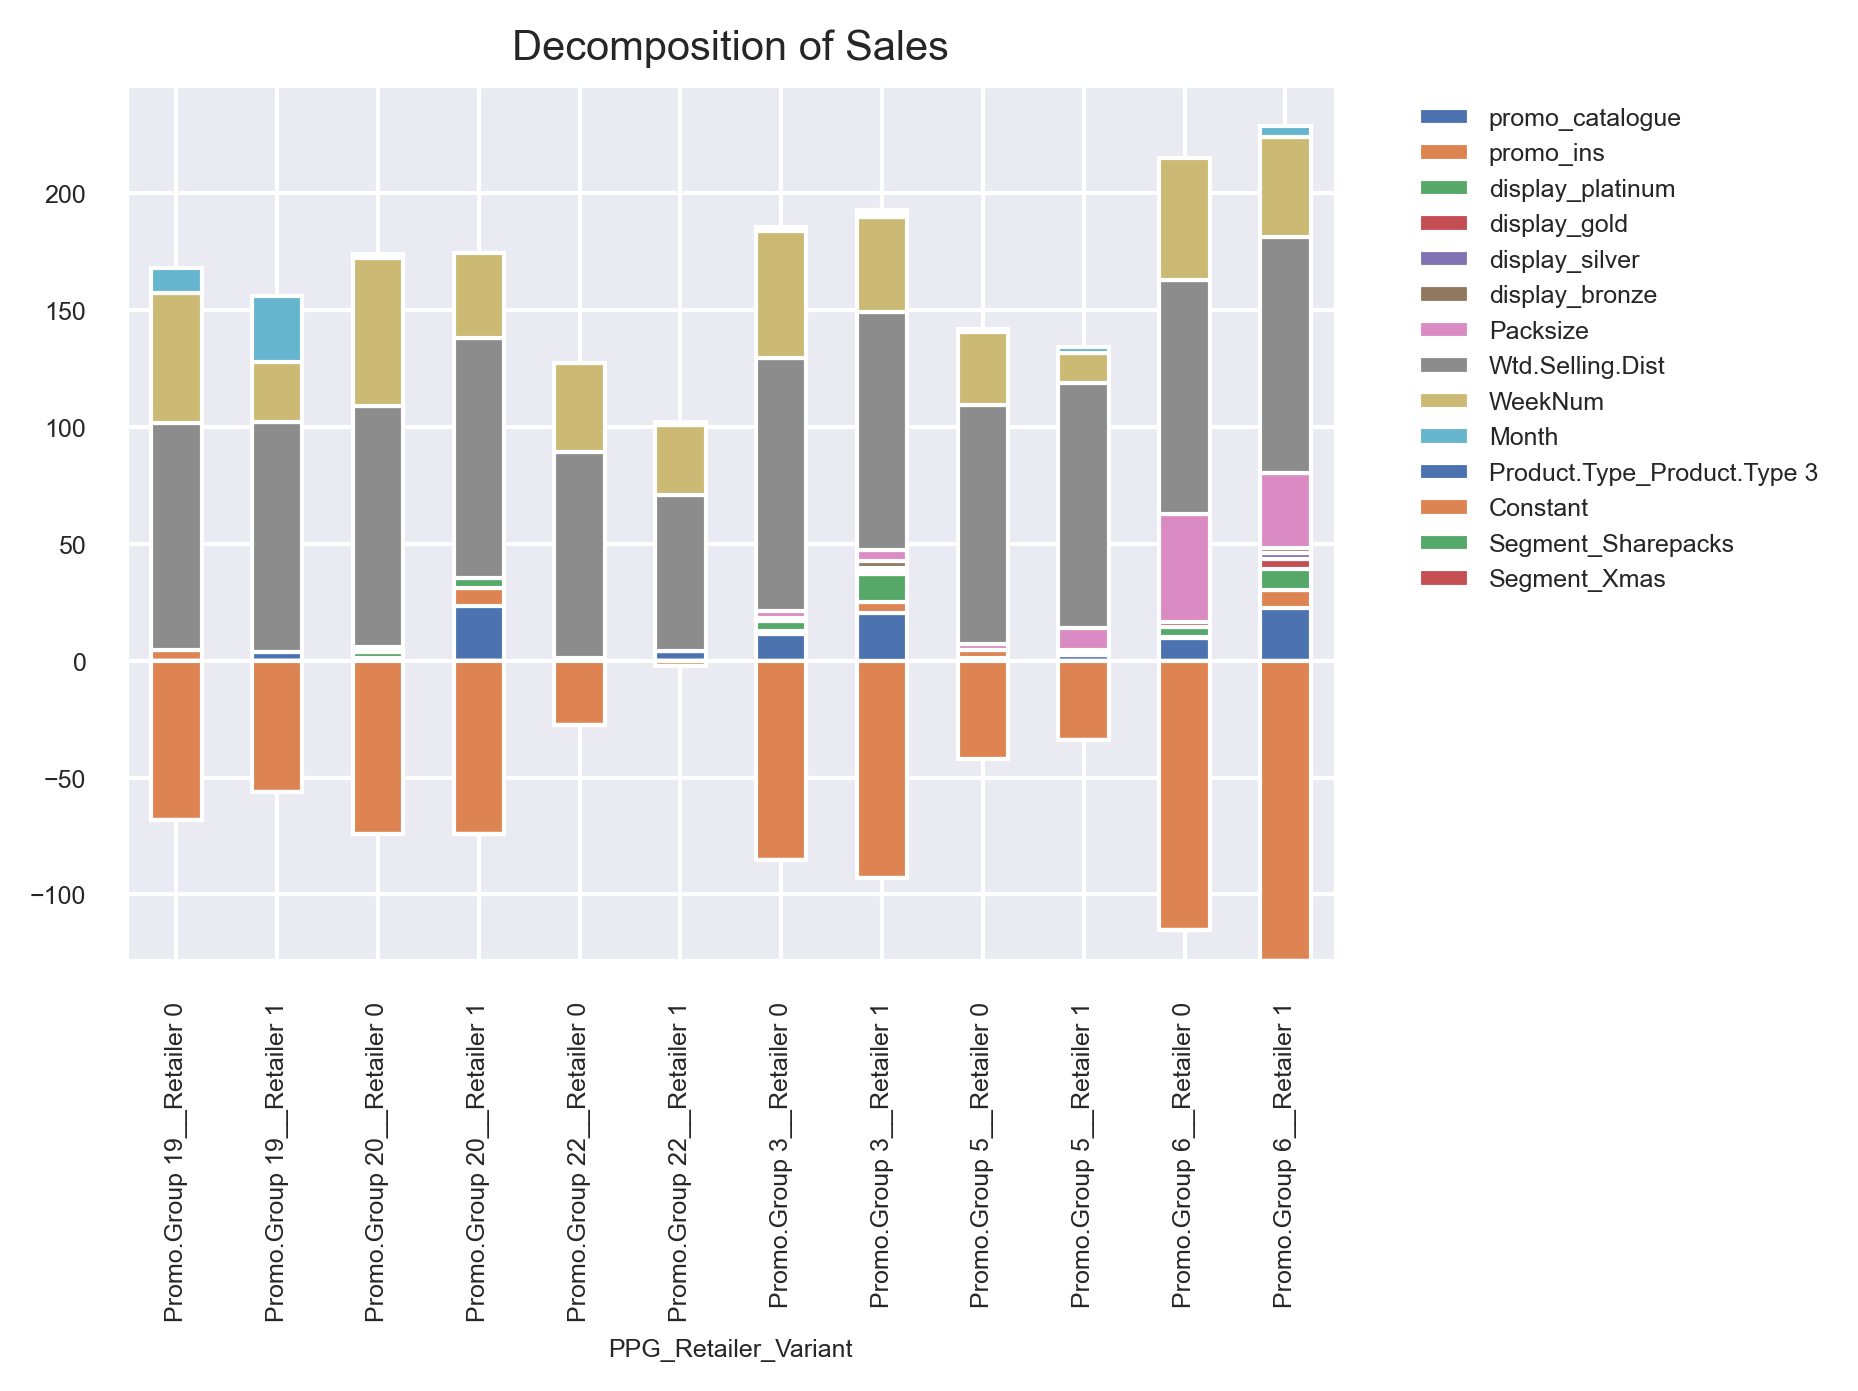

In [ ]:
# Calculating sales decomposition for various PPG x Retailer
decompose_sales = pd.DataFrame()
for dataset in os.listdir(ppg_retailer_contributions_percent):
    df = pd.read_csv(f"{ppg_retailer_contributions_percent}\{dataset}")
    for k, v in model_dict.items():
        if dataset.startswith(k):
            model = v
            df_contribute = df[df.Model==model]
            relative_contribution = np.round(100 * df_contribute.iloc[:,1:]/df_contribute.iloc[:,1:].sum(axis=1).iloc[0], 2)
            columns = list(relative_contribution.columns)
            relative_contribution['PPG_Retailer_Variant'] = k
            relative_contribution['Model'] = v
            relative_contribution = relative_contribution[['PPG_Retailer_Variant','Model']+columns]
            decompose_sales = decompose_sales.append(relative_contribution)

temp = decompose_sales.set_index('PPG_Retailer_Variant')
ax = temp.plot(kind='bar', stacked=True)
sns.move_legend(ax, "upper left",bbox_to_anchor=(1.05, 1),fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('PPG_Retailer_Variant', loc='center', fontsize=6)
plt.title('Decomposition of Sales',fontsize=10)
plt.tight_layout();

if overwrite_permission:
    decompose_sales.to_csv(f"{final_report_folder}\Decomposition_of_Sales.csv", index=False)
    plt.savefig(f"{final_report_folder}\Decomposition_of_Sales.png")